In [1]:
using Revise

In [7]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
working_dir = "C:\\Google Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan\\scan_3frequencies"
;

In [8]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if times[i][end] * 1e-3 ≈ t_end
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        if distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end) < 0.5
            n += 1
        end
    end
    return n
end
;

### Set up the molecule

In [9]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

In [10]:
# initial_params = [
#     2.0, 0.05, 0.05,
#     4.0, -1.0, 0.5
# ]

global scan_counter = 1

initial_params = [
    0.0, 0.0, 0.0,
    0.0, 0.0, 0.0
]

"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = x[5]*Γ
    Δ4 = x[6]*Γ
    
    temp = @with_unit 0.1 "mK"
    diameter = @with_unit 0.6 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end = 20e-3, n_values = 20,
        pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
        s1=s1, s2=0.0, s3=s3, s4=s4,
        Δ1=Δ1, Δ2=-0.8Γ, Δ3=Δ3, Δ4=Δ4,
        B_gradient = 60,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time = 5e-3)
    
    results = simulate_particles_v2(package, params)
    
    _goodness = goodness(params.t_end, results)
    println(results.photons_scattered)
    println(_goodness)
    
    # Save the results
    serialize(working_dir * "\\" * string(scan_counter) * ".jl", results)
    global scan_counter += 1
    
    return _goodness
end
;    

In [11]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(6,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(1, 1)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000)

opt = BOpt(f,
           model,
           UpperConfidenceBound(),                   # type of acquisition
           modeloptimizer,                        
           [0.0, 0.0, 0.0, +0.0, -2.0, +0.0],        # lowerbounds
           [5.0, 0.3, 0.3, +4.0, +0.0, +2.0],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 2000,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 5,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 1000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

result = boptimize!(opt)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


[1, 3, 5, 7, 8, 12, 13, 14, 16, 17, 20]
[7011.0, 406.0, 6064.0, 2252.0, 6040.0, 962.0, 6970.0, 6432.0, 6380.0, 3058.0, 6317.0, 6172.0, 6052.0, 5871.0, 4283.0, 6400.0, 5922.0, 6532.0, 4357.0, 6026.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Int64[]
[6045.0, 9313.0, 4516.0, 8651.0, 3629.0, 6529.0, 5341.0, 955.0, 3606.0, 26.0, 2712.0, 3222.0, 5568.0, 5606.0, 4509.0, 6963.0, 3402.0, 4747.0, 1267.0, 2010.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


[1, 2, 3, 4, 5, 9, 11, 13, 16, 19]
[12724.0, 12569.0, 13257.0, 12684.0, 12977.0, 6194.0, 5027.0, 2496.0, 13209.0, 11694.0, 12730.0, 12454.0, 12851.0, 5342.0, 11689.0, 13121.0, 3731.0, 238.0, 13169.0, 1559.0]
10


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


[2, 5, 10, 11, 12, 17]
[2135.0, 12707.0, 1184.0, 10081.0, 13529.0, 1021.0, 1147.0, 1463.0, 5037.0, 12459.0, 12375.0, 12848.0, 7275.0, 6793.0, 6225.0, 7133.0, 12157.0, 6682.0, 13140.0, 1447.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


Int64[]
[5417.0, 2689.0, 4659.0, 1240.0, 8906.0, 10116.0, 3280.0, 5138.0, 2263.0, 3161.0, 5316.0, 4736.0, 307.0, 6385.0, 3471.0, 9794.0, 6286.0, 3659.0, 56.0, 4869.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[3, 18]
[2824.0, 426.0, 24520.0, 17352.0, 9157.0, 9806.0, 6524.0, 7412.0, 8977.0, 4600.0, 6632.0, 6719.0, 3951.0, 361.0, 10972.0, 9325.0, 20386.0, 25216.0, 9931.0, 6256.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


Int64[]
[3714.0, 5314.0, 949.0, 797.0, 3934.0, 4033.0, 3242.0, 4861.0, 4581.0, 2366.0, 4339.0, 1841.0, 3415.0, 4111.0, 582.0, 3407.0, 3413.0, 3760.0, 2508.0, 3563.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[6, 11, 13, 17, 18, 19, 20]
[3904.0, 1285.0, 2639.0, 1071.0, 10442.0, 13363.0, 1231.0, 1237.0, 5307.0, 4108.0, 13568.0, 705.0, 13531.0, 4518.0, 99.0, 3672.0, 13505.0, 13181.0, 13249.0, 13575.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


[2, 7, 9, 10, 11, 14]
[3788.0, 7207.0, 2879.0, 39.0, 570.0, 4105.0, 7293.0, 6139.0, 7487.0, 7182.0, 7506.0, 2847.0, 3316.0, 5581.0, 4216.0, 4197.0, 1144.0, 2865.0, 1338.0, 1226.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 14, 15, 17]
[17692.0, 2397.0, 10508.0, 11725.0, 335.0, 7583.0, 2377.0, 14415.0, 1946.0, 9869.0, 12634.0, 11878.0, 924.0, 16765.0, 18012.0, 6452.0, 17105.0, 8088.0, 2793.0, 9538.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


[1, 7, 11, 15, 18]
[14484.0, 11659.0, 13276.0, 11026.0, 10664.0, 243.0, 14343.0, 379.0, 1251.0, 2714.0, 14068.0, 12981.0, 10593.0, 3154.0, 14862.0, 7193.0, 1259.0, 13966.0, 2446.0, 7635.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


Int64[]
[12648.0, 7326.0, 9951.0, 3070.0, 8655.0, 9828.0, 11871.0, 3997.0, 2640.0, 218.0, 9861.0, 2054.0, 13683.0, 4626.0, 19968.0, 5157.0, 13313.0, 10471.0, 6343.0, 16390.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


Int64[]
[5812.0, 926.0, 6521.0, 4111.0, 12874.0, 12166.0, 1536.0, 7408.0, 10216.0, 11018.0, 214.0, 7410.0, 2684.0, 4695.0, 7516.0, 10340.0, 3396.0, 4838.0, 5822.0, 3510.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[5, 10, 12]
[9076.0, 11316.0, 1985.0, 7847.0, 24274.0, 6581.0, 3243.0, 16099.0, 8164.0, 24222.0, 20041.0, 24390.0, 2122.0, 21544.0, 745.0, 19589.0, 18206.0, 508.0, 2425.0, 2797.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


[1, 2, 5, 6, 7, 8, 9, 12, 14, 16, 18, 19, 20]
[9900.0, 9606.0, 1339.0, 3761.0, 10031.0, 9978.0, 9338.0, 9486.0, 10203.0, 2704.0, 4476.0, 9439.0, 6333.0, 9742.0, 6874.0, 9710.0, 9038.0, 9555.0, 9462.0, 9834.0]
10


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[4, 7, 11, 13, 18]
[1734.0, 1265.0, 1208.0, 3490.0, 107.0, 2807.0, 3563.0, 2661.0, 3295.0, 830.0, 3511.0, 1209.0, 3464.0, 2869.0, 2965.0, 1979.0, 3282.0, 3534.0, 3017.0, 2682.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[1, 2, 7, 9, 10, 14, 15, 16, 17, 19]
[4140.0, 5240.0, 2972.0, 1820.0, 2594.0, 1976.0, 4605.0, 4385.0, 4739.0, 5021.0, 3263.0, 4100.0, 4565.0, 4422.0, 4936.0, 5156.0, 4793.0, 4551.0, 4885.0, 4282.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


Int64[]
[1087.0, 254.0, 6018.0, 99.0, 13008.0, 4642.0, 7352.0, 1014.0, 8.0, 5602.0, 4419.0, 10109.0, 7278.0, 1563.0, 5768.0, 11416.0, 7385.0, 4009.0, 6870.0, 10123.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


[8, 12, 13, 15, 16]
[10941.0, 4260.0, 474.0, 6344.0, 3969.0, 9150.0, 11388.0, 11139.0, 529.0, 2145.0, 6307.0, 15190.0, 17075.0, 2407.0, 15895.0, 12563.0, 14877.0, 10243.0, 2994.0, 646.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


[3, 5, 6, 8, 11, 12, 14]
[5984.0, 16012.0, 17278.0, 3646.0, 16843.0, 16975.0, 7089.0, 16962.0, 4405.0, 11089.0, 16988.0, 16873.0, 5012.0, 18183.0, 13008.0, 14677.0, 13647.0, 5792.0, 8356.0, 6944.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:02:09


[2, 3, 5, 12, 13, 14, 15, 16, 17, 18, 20]
[373.0, 5809.0, 5024.0, 1162.0, 5928.0, 508.0, 1563.0, 1551.0, 3251.0, 1754.0, 2499.0, 6398.0, 5418.0, 4979.0, 6031.0, 6242.0, 5359.0, 5977.0, 5128.0, 6005.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 4, 5, 13, 14, 17]
[24105.0, 24578.0, 4330.0, 22325.0, 25736.0, 5497.0, 19786.0, 3363.0, 10086.0, 6507.0, 2790.0, 10191.0, 23436.0, 24842.0, 12289.0, 8466.0, 24919.0, 5129.0, 1498.0, 10008.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


[6, 10, 18]
[14740.0, 1237.0, 2819.0, 7364.0, 6740.0, 26514.0, 1997.0, 9228.0, 24595.0, 26800.0, 14019.0, 10925.0, 2376.0, 5149.0, 1673.0, 2695.0, 280.0, 26802.0, 6719.0, 10081.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 8, 12, 14, 18, 19, 20]
[44.0, 10286.0, 5261.0, 2875.0, 1926.0, 6137.0, 10110.0, 10676.0, 2122.0, 9056.0, 7727.0, 11103.0, 8586.0, 10997.0, 5997.0, 6337.0, 6774.0, 10316.0, 10620.0, 11728.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18Progress:  35%|███████████████                          |  ETA: 0:02:12


[2, 3, 5, 7, 8, 9, 11, 13, 14, 19, 20]
[4497.0, 4887.0, 4951.0, 3467.0, 5001.0, 3842.0, 5158.0, 5106.0, 4686.0, 2134.0, 4962.0, 4152.0, 5120.0, 5006.0, 535.0, 3585.0, 306.0, 1986.0, 5099.0, 5037.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[2, 4, 9, 10, 12, 14, 15, 17, 20]
[8832.0, 19939.0, 5451.0, 20562.0, 7254.0, 4677.0, 6299.0, 5317.0, 22182.0, 19717.0, 15886.0, 20838.0, 20969.0, 20446.0, 20096.0, 9112.0, 20333.0, 2910.0, 57.0, 20835.0]
9


Progress: 100%|█████████████████████████████████████████| Time: 0:01:57


[1, 4, 5, 6, 10, 14, 18, 20]
[11652.0, 1137.0, 6493.0, 11269.0, 12075.0, 11298.0, 8325.0, 8671.0, 4569.0, 12229.0, 7308.0, 699.0, 2741.0, 12536.0, 9739.0, 2351.0, 1913.0, 11594.0, 2849.0, 10603.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


Int64[]
[5113.0, 4120.0, 6780.0, 6465.0, 3844.0, 8132.0, 1935.0, 15185.0, 7891.0, 175.0, 8226.0, 4454.0, 5140.0, 10470.0, 5975.0, 5406.0, 14155.0, 6239.0, 6845.0, 4680.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Int64[]
[4550.0, 5862.0, 3724.0, 2384.0, 2112.0, 3735.0, 4563.0, 4718.0, 3617.0, 3372.0, 4464.0, 327.0, 3687.0, 3199.0, 4067.0, 4318.0, 2505.0, 4138.0, 782.0, 3034.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[3, 10, 20]
[11983.0, 8378.0, 25879.0, 515.0, 12951.0, 9700.0, 772.0, 2561.0, 3467.0, 25571.0, 4515.0, 7612.0, 1191.0, 769.0, 16791.0, 2741.0, 1349.0, 1364.0, 4209.0, 25501.0]
3


[ Info: 2023-10-02T22:03:15.712	iteration: 30	current optimum: 10.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:34

[1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20]
[6243.0, 6354.0, 5836.0, 6653.0, 6322.0, 2488.0, 6383.0, 6050.0, 6360.0, 6472.0, 6190.0, 5541.0, 6189.0, 6394.0, 6711.0, 2780.0, 2205.0, 6347.0, 6346.0, 6657.0]
0

[ Info: 2023-10-02T22:05:55.854	iteration: 31	current optimum: 10.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:48
[ Info: 2023-10-02T22:07:43.922	iteration: 32	current optimum: 10.0


[1, 3, 5, 6, 9, 11, 12, 13, 14, 15, 17, 18]
[6514.0, 5102.0, 6509.0, 2610.0, 6330.0, 6485.0, 3493.0, 413.0, 6163.0, 5156.0, 6318.0, 5901.0, 6487.0, 6394.0, 6648.0, 2369.0, 6156.0, 6622.0, 5790.0, 1194.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:02:29
[ Info: 2023-10-02T22:10:13.102	iteration: 33	current optimum: 10.0


[2, 4, 14, 18, 20]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48
[ Info: 2023-10-02T22:12:02.160	iteration: 34	current optimum: 10.0


[12, 19]
[19720.0, 10477.0, 1654.0, 3500.0, 7025.0, 12521.0, 2884.0, 6186.0, 6286.0, 8564.0, 2967.0, 18295.0, 4942.0, 4366.0, 2194.0, 9089.0, 2229.0, 7984.0, 20841.0, 14461.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:41


[1, 9, 20]
[11818.0, 4785.0, 9295.0, 678.0, 2199.0, 3771.0, 2984.0, 6407.0, 11900.0, 7388.0, 1854.0, 8964.0, 4238.0, 6365.0, 2912.0, 8569.0, 7232.0, 9459.0, 6251.0, 9736.0]
1

[ Info: 2023-10-02T22:14:44.153	iteration: 35	current optimum: 10.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


[8, 9, 10, 15, 16, 17, 20]
[412.0, 350.0, 370.0, 526.0, 182.0, 341.0, 160.0, 602.0, 535.0, 595.0, 331.0, 323.0, 342.0, 188.0, 462.0, 513.0, 510.0, 301.0, 259.0, 442.0]
0


[ Info: 2023-10-02T22:17:34.033	iteration: 36	current optimum: 10.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25
[ Info: 2023-10-02T22:18:59.936	iteration: 37	current optimum: 10.0


[1, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 20]
[3539.0, 3442.0, 3004.0, 3533.0, 3589.0, 3499.0, 3276.0, 3715.0, 3656.0, 3806.0, 3478.0, 3440.0, 3565.0, 2960.0, 408.0, 3550.0, 2806.0, 924.0, 316.0, 3536.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
[ Info: 2023-10-02T22:20:13.171	iteration: 38	current optimum: 10.0


[2, 5, 9, 11, 13, 14, 15, 16]
[3563.0, 14013.0, 4264.0, 12693.0, 13264.0, 10605.0, 4199.0, 8178.0, 13048.0, 1330.0, 12993.0, 3439.0, 13028.0, 13759.0, 13290.0, 13080.0, 1998.0, 2665.0, 9405.0, 4870.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:02:05
[ Info: 2023-10-02T22:22:19.076	iteration: 39	current optimum: 10.0


[4, 7, 8, 9, 12, 14, 15, 16, 17, 18, 20]
[2458.0, 489.0, 1489.0, 2786.0, 1944.0, 2731.0, 2554.0, 2576.0, 2570.0, 2083.0, 941.0, 2631.0, 1880.0, 2796.0, 2770.0, 2828.0, 2782.0, 2576.0, 2599.0, 2750.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
[ Info: 2023-10-02T22:23:11.565	iteration: 40	current optimum: 10.0


[14]
[4238.0, 28936.0, 4143.0, 5557.0, 712.0, 4491.0, 22675.0, 1542.0, 27942.0, 240.0, 11494.0, 5191.0, 3647.0, 43162.0, 21428.0, 2918.0, 6518.0, 2287.0, 17368.0, 673.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
[ Info: 2023-10-02T22:23:24.850	iteration: 41	current optimum: 10.0


Int64[]
[3935.0, 132.0, 729.0, 368.0, 3162.0, 3453.0, 2230.0, 2636.0, 2935.0, 3968.0, 2431.0, 2978.0, 3795.0, 2270.0, 3046.0, 3305.0, 2452.0, 3873.0, 3018.0, 2783.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
[ Info: 2023-10-02T22:24:36.120	iteration: 42	current optimum: 10.0


[1, 3, 4, 12, 13, 17, 18, 19]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
[ Info: 2023-10-02T22:24:53.303	iteration: 43	current optimum: 10.0


Int64[]
[4176.0, 16048.0, 4085.0, 6875.0, 5062.0, 15044.0, 4644.0, 488.0, 5103.0, 5714.0, 6349.0, 3738.0, 5705.0, 7240.0, 4608.0, 5249.0, 2253.0, 272.0, 7737.0, 8999.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-02T22:25:54.303	iteration: 44	current optimum: 10.0


[12, 18, 19]
[11094.0, 15469.0, 2887.0, 1453.0, 7367.0, 3098.0, 17321.0, 2927.0, 1364.0, 2310.0, 4770.0, 20718.0, 19014.0, 6016.0, 8286.0, 11354.0, 5501.0, 21273.0, 21711.0, 13868.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-02T22:26:58.263	iteration: 45	current optimum: 10.0


[13, 15, 20]
[5571.0, 2207.0, 104.0, 14301.0, 17575.0, 23238.0, 12603.0, 9307.0, 4099.0, 10441.0, 8739.0, 5401.0, 25648.0, 5223.0, 26562.0, 557.0, 3453.0, 16391.0, 6930.0, 20157.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[1, 3, 4, 5, 6, 7, 9, 12, 13, 14, 15, 17, 18, 20]
[10571.0, 8433.0, 11489.0, 11127.0, 10365.0, 10380.0, 10784.0, 8143.0, 10683.0, 3588.0, 4845.0, 11078.0, 11047.0, 11367.0, 11015.0, 1667.0, 11378.0, 11109.0, 9160.0, 10977.0]
14


[ Info: 2023-10-02T22:28:12.464	iteration: 46	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:16
[ Info: 2023-10-02T22:30:29.344	iteration: 47	current optimum: 14.0


[1, 2, 6, 8, 10, 12, 14, 17, 19]
[1889.0, 1957.0, 490.0, 1692.0, 618.0, 1947.0, 1470.0, 1981.0, 862.0, 1931.0, 912.0, 1837.0, 896.0, 1812.0, 1162.0, 1089.0, 1922.0, 847.0, 1811.0, 484.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:04:31
[ Info: 2023-10-02T22:35:01.167	iteration: 48	current optimum: 14.0


[2, 3, 4, 10, 11, 12, 15, 16, 17, 19, 20]
[735.0, 1576.0, 1629.0, 1566.0, 1370.0, 291.0, 1384.0, 911.0, 399.0, 1569.0, 1503.0, 1486.0, 1147.0, 640.0, 1530.0, 1623.0, 1472.0, 1141.0, 1663.0, 1584.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39
[ Info: 2023-10-02T22:36:40.417	iteration: 49	current optimum: 14.0


[1, 2, 3, 8, 9, 10, 12, 14, 15, 19, 20]
[5953.0, 4925.0, 5765.0, 1471.0, 3850.0, 5976.0, 3041.0, 5411.0, 6015.0, 5419.0, 1486.0, 5937.0, 3734.0, 6183.0, 4454.0, 2303.0, 4988.0, 4768.0, 5029.0, 4725.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
[ Info: 2023-10-02T22:37:59.435	iteration: 50	current optimum: 14.0


[16, 18]
[1893.0, 761.0, 1010.0, 21234.0, 3857.0, 2155.0, 4860.0, 11049.0, 10968.0, 8040.0, 12454.0, 5864.0, 4197.0, 13142.0, 18616.0, 13183.0, 10927.0, 14087.0, 9032.0, 18248.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38
[ Info: 2023-10-02T22:39:38.167	iteration: 51	current optimum: 14.0


[5, 6, 7, 9, 10, 14, 16, 19, 20]
[352.0, 1276.0, 732.0, 1681.0, 2045.0, 2064.0, 2046.0, 1690.0, 2115.0, 1937.0, 522.0, 251.0, 212.0, 2002.0, 740.0, 2081.0, 862.0, 1852.0, 1909.0, 1950.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
[ Info: 2023-10-02T22:40:06.580	iteration: 52	current optimum: 14.0


Int64[]
[4188.0, 185.0, 4304.0, 7444.0, 15133.0, 6687.0, 254.0, 1267.0, 1876.0, 6069.0, 1602.0, 3477.0, 7493.0, 7059.0, 1939.0, 4443.0, 4152.0, 769.0, 5174.0, 6978.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 19]
[6728.0, 6981.0, 7224.0, 7195.0, 6998.0, 7102.0, 7696.0, 7096.0, 2617.0, 253.0, 4817.0, 743.0, 7069.0, 7019.0, 7178.0, 1901.0, 4266.0, 7865.0, 6922.0, 7230.0]
0

[ Info: 2023-10-02T22:41:43.289	iteration: 53	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14
[ Info: 2023-10-02T22:42:57.912	iteration: 54	current optimum: 14.0


[9, 10]
[6685.0, 4047.0, 7334.0, 5190.0, 283.0, 544.0, 7316.0, 1944.0, 16805.0, 24091.0, 7163.0, 8443.0, 18626.0, 15875.0, 4054.0, 4284.0, 930.0, 10094.0, 13151.0, 19082.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25

[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
[10585.0, 11069.0, 3169.0, 10856.0, 1076.0, 10865.0, 9972.0, 11554.0, 5848.0, 10765.0, 2937.0, 10403.0, 6597.0, 10431.0, 6279.0, 11301.0, 8763.0, 10230.0, 7777.0, 10776.0]
5


[ Info: 2023-10-02T22:44:23.809	iteration: 55	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00
[ Info: 2023-10-02T22:46:24.392	iteration: 56	current optimum: 14.0


[1, 2, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 19]
[1814.0, 1704.0, 1259.0, 1712.0, 1603.0, 1731.0, 1721.0, 1758.0, 820.0, 1676.0, 636.0, 1665.0, 1720.0, 1712.0, 1735.0, 1692.0, 1759.0, 1332.0, 1716.0, 1393.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 20]
[2194.0, 2342.0, 960.0, 2184.0, 2199.0, 2074.0, 2136.0, 2288.0, 2051.0, 2295.0, 2031.0, 945.0, 1542.0, 2072.0, 2326.0, 2162.0, 2198.0, 2193.0, 1531.0, 2057.0]
1


[ Info: 2023-10-02T22:48:36.499	iteration: 57	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-10-02T22:49:46.746	iteration: 58	current optimum: 14.0


[1, 4, 5, 6, 8, 11, 15, 16, 17, 20]
[11493.0, 6633.0, 7007.0, 13096.0, 11572.0, 11458.0, 4708.0, 10922.0, 323.0, 8914.0, 10922.0, 6995.0, 4121.0, 9318.0, 11095.0, 10696.0, 12613.0, 1641.0, 1244.0, 10331.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


[3, 4, 7, 8, 10, 13, 17]
[810.0, 265.0, 1139.0, 1123.0, 643.0, 537.0, 1074.0, 1086.0, 1044.0, 1011.0, 643.0, 669.0, 1157.0, 520.0, 867.0, 352.0, 1082.0, 604.0, 536.0, 349.0]
0

[ Info: 2023-10-02T22:51:26.311	iteration: 59	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: 2023-10-02T22:52:22.795	iteration: 60	current optimum: 14.0


[11, 20]
[6757.0, 9455.0, 5816.0, 6524.0, 4559.0, 3814.0, 2202.0, 15292.0, 11401.0, 263.0, 16458.0, 404.0, 17181.0, 5751.0, 4871.0, 1314.0, 1044.0, 7880.0, 5346.0, 16565.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-02T22:53:11.828	iteration: 61	current optimum: 14.0


Int64[]
[2771.0, 4628.0, 5239.0, 11761.0, 7819.0, 10603.0, 12938.0, 793.0, 2474.0, 4593.0, 6263.0, 9019.0, 5558.0, 3897.0, 7126.0, 242.0, 1002.0, 430.0, 6243.0, 3792.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


[2]
[431.0, 32118.0, 3084.0, 24284.0, 29968.0, 18710.0, 14348.0, 18319.0, 23621.0, 409.0, 9011.0, 10820.0, 9028.0, 30363.0, 13383.0, 2734.0, 5605.0, 11989.0, 18154.0, 16203.0]
1


[ Info: 2023-10-02T22:54:06.554	iteration: 62	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06
[ Info: 2023-10-02T22:55:13.488	iteration: 63	current optimum: 14.0


[6]
[5765.0, 8756.0, 940.0, 29424.0, 12749.0, 19705.0, 14226.0, 4492.0, 16039.0, 16276.0, 2485.0, 13293.0, 206.0, 2167.0, 20037.0, 5231.0, 4400.0, 14189.0, 13997.0, 516.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06
[ Info: 2023-10-02T22:56:20.036	iteration: 64	current optimum: 14.0


[2, 3, 4, 8, 9, 10, 13, 14, 15, 16]
[7700.0, 7219.0, 8263.0, 7520.0, 4590.0, 568.0, 2773.0, 7385.0, 6948.0, 7458.0, 5919.0, 6205.0, 7018.0, 7206.0, 7285.0, 7430.0, 7383.0, 595.0, 7362.0, 3981.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12
[ Info: 2023-10-02T22:57:32.486	iteration: 65	current optimum: 14.0


[5, 10]
[1746.0, 3655.0, 5581.0, 3006.0, 9732.0, 7879.0, 4673.0, 11073.0, 2282.0, 10962.0, 321.0, 12736.0, 11728.0, 952.0, 11492.0, 1964.0, 7207.0, 13193.0, 9741.0, 9752.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-02T22:58:32.723	iteration: 66	current optimum: 14.0


[5, 9, 10]
[7142.0, 8253.0, 990.0, 9474.0, 19279.0, 5623.0, 8179.0, 2988.0, 19334.0, 20495.0, 4320.0, 14697.0, 12383.0, 9082.0, 7578.0, 16249.0, 190.0, 6464.0, 347.0, 3856.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34
[ Info: 2023-10-02T23:00:07.125	iteration: 67	current optimum: 14.0


[3, 11, 20]
[204.0, 183.0, 440.0, 299.0, 268.0, 386.0, 217.0, 136.0, 162.0, 161.0, 439.0, 295.0, 314.0, 253.0, 285.0, 347.0, 212.0, 457.0, 234.0, 570.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
[ Info: 2023-10-02T23:01:08.734	iteration: 68	current optimum: 14.0


[7]
[7895.0, 9915.0, 5956.0, 2687.0, 11933.0, 17619.0, 23165.0, 14356.0, 843.0, 3036.0, 21167.0, 1570.0, 15519.0, 19552.0, 12523.0, 19798.0, 4743.0, 16564.0, 5574.0, 9818.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
[ Info: 2023-10-02T23:02:10.435	iteration: 69	current optimum: 14.0


[4, 9, 11]
[9436.0, 17240.0, 12732.0, 27520.0, 225.0, 645.0, 7798.0, 1890.0, 22096.0, 4667.0, 26142.0, 9403.0, 15792.0, 318.0, 1937.0, 17392.0, 7710.0, 24765.0, 8081.0, 2041.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
[ Info: 2023-10-02T23:03:25.589	iteration: 70	current optimum: 14.0


[3, 11, 12, 20]
[6370.0, 6067.0, 19216.0, 1726.0, 6920.0, 9537.0, 7931.0, 12816.0, 8533.0, 73.0, 16691.0, 15708.0, 4857.0, 888.0, 340.0, 9182.0, 9627.0, 4527.0, 9413.0, 15090.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
[ Info: 2023-10-02T23:04:23.365	iteration: 71	current optimum: 14.0


[5, 18]
[6229.0, 5219.0, 6293.0, 6997.0, 28442.0, 7535.0, 9018.0, 13061.0, 7512.0, 8490.0, 8254.0, 16237.0, 10955.0, 7013.0, 538.0, 6732.0, 16214.0, 21487.0, 1277.0, 8313.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: 2023-10-02T23:05:20.252	iteration: 72	current optimum: 14.0


[12, 15]
[3745.0, 4822.0, 2730.0, 4698.0, 3948.0, 1909.0, 1453.0, 4052.0, 2176.0, 16045.0, 475.0, 20384.0, 160.0, 10552.0, 19644.0, 11358.0, 10709.0, 2949.0, 10113.0, 3889.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


[1, 3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 18, 20]
[2442.0, 1693.0, 2455.0, 2436.0, 2245.0, 2316.0, 2505.0, 2379.0, 1021.0, 2511.0, 680.0, 480.0, 2275.0, 1485.0, 2615.0, 785.0, 2497.0, 2457.0, 1671.0, 2358.0]
2

[ Info: 2023-10-02T23:07:15.728	iteration: 73	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-02T23:08:09.749	iteration: 74	current optimum: 14.0


[2]
[10379.0, 25343.0, 1729.0, 4456.0, 384.0, 6130.0, 13.0, 11154.0, 13275.0, 20650.0, 9479.0, 6906.0, 8038.0, 1941.0, 14217.0, 4735.0, 7276.0, 4471.0, 420.0, 7197.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
[ Info: 2023-10-02T23:09:25.241	iteration: 75	current optimum: 14.0


[2, 5, 7, 9, 10, 11, 15, 17, 18, 19]
[1052.0, 18295.0, 2950.0, 2078.0, 18639.0, 8719.0, 15743.0, 11984.0, 18422.0, 18113.0, 17775.0, 455.0, 6116.0, 17180.0, 18891.0, 5129.0, 18278.0, 17884.0, 19115.0, 4719.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


[1, 17, 20]
[25276.0, 4092.0, 207.0, 20344.0, 13085.0, 14150.0, 17654.0, 2460.0, 17791.0, 6839.0, 4953.0, 4294.0, 3942.0, 16962.0, 10896.0, 11970.0, 25188.0, 15269.0, 23169.0, 25526.0]
3


[ Info: 2023-10-02T23:10:27.931	iteration: 76	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-02T23:11:31.072	iteration: 77	current optimum: 14.0


[1, 3, 5, 9, 10, 12, 13, 14, 18]
[8842.0, 7778.0, 8262.0, 5380.0, 8719.0, 6959.0, 5531.0, 7132.0, 8824.0, 8416.0, 4595.0, 9812.0, 8940.0, 8582.0, 4851.0, 4686.0, 2824.0, 8521.0, 8175.0, 1913.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 4, 6, 9, 14, 15, 18, 19]
[818.0, 10989.0, 8701.0, 10314.0, 1003.0, 10628.0, 1550.0, 3556.0, 12954.0, 3563.0, 3618.0, 6014.0, 2739.0, 11265.0, 10774.0, 1831.0, 4592.0, 12127.0, 10520.0, 5619.0]
7


[ Info: 2023-10-02T23:12:32.706	iteration: 78	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-02T23:13:32.802	iteration: 79	current optimum: 14.0


[1, 5, 8, 15, 18, 19]
[8707.0, 5224.0, 4965.0, 7636.0, 9651.0, 2107.0, 3477.0, 8318.0, 4331.0, 6206.0, 7187.0, 6814.0, 1780.0, 3909.0, 8821.0, 9202.0, 1893.0, 9977.0, 8744.0, 2789.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: 2023-10-02T23:14:21.205	iteration: 80	current optimum: 14.0


Int64[]
[4576.0, 2815.0, 3857.0, 3495.0, 1335.0, 4942.0, 1731.0, 4381.0, 7838.0, 642.0, 1964.0, 6709.0, 4149.0, 2515.0, 2801.0, 8203.0, 1115.0, 1271.0, 4883.0, 1378.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[2, 3, 5, 6, 7, 8, 10, 13, 14, 15, 19, 20]
[7933.0, 10533.0, 9621.0, 10173.0, 10533.0, 9228.0, 10067.0, 9920.0, 3029.0, 10475.0, 5896.0, 7283.0, 9827.0, 9700.0, 10050.0, 6064.0, 9515.0, 4440.0, 10253.0, 9381.0]
8


[ Info: 2023-10-02T23:15:45.517	iteration: 81	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14
[ Info: 2023-10-02T23:17:00.072	iteration: 82	current optimum: 14.0


[1, 2, 5, 6, 7, 8, 10, 11, 12, 14, 15, 17]
[3827.0, 3757.0, 3953.0, 4227.0, 4583.0, 4630.0, 3804.0, 3941.0, 335.0, 3937.0, 4783.0, 4347.0, 2478.0, 4252.0, 4366.0, 2477.0, 4474.0, 3536.0, 4982.0, 959.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[5, 11, 14, 19]
[2729.0, 6436.0, 4402.0, 5457.0, 10359.0, 6086.0, 9367.0, 2656.0, 339.0, 7589.0, 8016.0, 12731.0, 8555.0, 14089.0, 2088.0, 9818.0, 4115.0, 3204.0, 10134.0, 5680.0]
0


[ Info: 2023-10-02T23:18:26.107	iteration: 83	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
[ Info: 2023-10-02T23:19:33.676	iteration: 84	current optimum: 14.0


[2, 4, 8, 9, 11, 12, 13, 15, 18, 20]
[6220.0, 8130.0, 2276.0, 7189.0, 6201.0, 60.0, 6099.0, 7378.0, 7391.0, 2328.0, 6976.0, 6486.0, 8211.0, 5078.0, 7228.0, 2805.0, 5670.0, 7705.0, 5672.0, 6578.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
[ Info: 2023-10-02T23:20:24.915	iteration: 85	current optimum: 14.0


[11, 14]
[2914.0, 1162.0, 6.0, 1874.0, 5068.0, 23.0, 4333.0, 2311.0, 3056.0, 3571.0, 9081.0, 544.0, 2548.0, 8660.0, 4791.0, 4624.0, 1434.0, 2214.0, 1848.0, 2276.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-10-02T23:21:35.933	iteration: 86	current optimum: 14.0


[6, 17, 18]
[660.0, 970.0, 5933.0, 5210.0, 7890.0, 9635.0, 43.0, 3451.0, 2202.0, 5943.0, 5515.0, 6804.0, 4563.0, 5612.0, 7176.0, 4668.0, 6669.0, 7347.0, 2937.0, 4547.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


[16]
[5449.0, 7388.0, 18280.0, 720.0, 15529.0, 10165.0, 2189.0, 17513.0, 4623.0, 13381.0, 6652.0, 6631.0, 6947.0, 6008.0, 30575.0, 30946.0, 21103.0, 1090.0, 11182.0, 6855.0]
0


[ Info: 2023-10-02T23:22:28.049	iteration: 87	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
[ Info: 2023-10-02T23:23:21.157	iteration: 88	current optimum: 14.0


[10, 18]
[7440.0, 6635.0, 6279.0, 5934.0, 5216.0, 8719.0, 6360.0, 2743.0, 5150.0, 16044.0, 6020.0, 5273.0, 1959.0, 8525.0, 7563.0, 5341.0, 6819.0, 16210.0, 13941.0, 782.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[7, 9, 20]
[3994.0, 1000.0, 13781.0, 5385.0, 6838.0, 6523.0, 18645.0, 4987.0, 18285.0, 18.0, 4463.0, 8617.0, 8959.0, 1709.0, 8975.0, 477.0, 2812.0, 3296.0, 3770.0, 

[ Info: 2023-10-02T23:24:19.459	iteration: 89	current optimum: 14.0


19889.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T23:25:14.954	iteration: 90	current optimum: 14.0


[12, 17]
[9403.0, 1845.0, 8503.0, 2202.0, 15128.0, 6238.0, 14701.0, 8400.0, 12093.0, 10163.0, 9306.0, 28193.0, 2403.0, 26014.0, 2579.0, 14553.0, 28055.0, 18300.0, 1981.0, 3910.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
[ Info: 2023-10-02T23:25:39.802	iteration: 91	current optimum: 14.0


Int64[]
[2537.0, 5130.0, 2359.0, 2028.0, 2948.0, 4040.0, 7109.0, 5489.0, 4867.0, 2334.0, 6506.0, 2762.0, 2581.0, 5062.0, 3917.0, 2638.0, 2939.0, 4077.0, 6909.0, 3840.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-02T23:26:43.126	iteration: 92	current optimum: 14.0


[1, 6, 7, 11, 14, 19, 20]
[19071.0, 9211.0, 5145.0, 18615.0, 1857.0, 20514.0, 19336.0, 18385.0, 5597.0, 3104.0, 19788.0, 5023.0, 3659.0, 19778.0, 6223.0, 2072.0, 970.0, 1053.0, 19836.0, 19636.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
[ Info: 2023-10-02T23:27:41.516	iteration: 93	current optimum: 14.0


[1, 11, 20]
[22756.0, 17906.0, 890.0, 1009.0, 8524.0, 7743.0, 6591.0, 5748.0, 5859.0, 6490.0, 22560.0, 18337.0, 9120.0, 2332.0, 2556.0, 13170.0, 21434.0, 2542.0, 1212.0, 23052.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
[ Info: 2023-10-02T23:28:38.509	iteration: 94	current optimum: 14.0


Int64[]
[11292.0, 5575.0, 1284.0, 5058.0, 9168.0, 7973.0, 6244.0, 2547.0, 248.0, 3359.0, 8430.0, 2530.0, 4582.0, 10545.0, 12872.0, 12832.0, 8312.0, 6651.0, 4115.0, 4508.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 7, 15]
[15645.0, 15050.0, 3523.0, 1185.0, 12509.0, 1375.0, 15703.0, 6166.0, 2970.0, 1665.0, 6062.0, 13469.0, 2704.0, 8083.0, 15910.0, 4850.0, 5371.0, 11225.0, 567.0, 12158.0]
3


[ Info: 2023-10-02T23:29:43.405	iteration: 95	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[3, 6, 7, 10, 14, 17, 18, 20]
[8830.0, 1981.0, 10798.0, 7532.0, 6982.0, 10788.0, 11081.0, 4198.0, 6118.0, 10319.0, 355.0, 3291.0, 2232.0, 10915.0, 3384.0, 5951.0, 10758.0, 10779.0, 926.0, 10766.0]
4


[ Info: 2023-10-02T23:30:41.492	iteration: 96	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[3, 8, 12, 13, 17, 18]
[5217.0, 5255.0, 8605.0, 3724.0, 2797.0, 1101.0, 7910.0, 8129.0, 2622.0, 3766.0, 7120.0, 8398.0, 8802.0, 8785.0, 3103.0, 4381.0, 8112.0, 8996.0, 6955.0, 1830.0]
1


[ Info: 2023-10-02T23:32:06.232	iteration: 97	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-02T23:33:07.199	iteration: 98	current optimum: 14.0


[3, 5, 6, 7, 10, 12, 17, 20]
[1759.0, 2299.0, 13395.0, 3915.0, 11805.0, 12216.0, 15013.0, 1616.0, 8394.0, 12292.0, 3544.0, 12464.0, 2372.0, 3009.0, 167.0, 1543.0, 11904.0, 6419.0, 3440.0, 14051.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
[ Info: 2023-10-02T23:34:14.755	iteration: 99	current optimum: 14.0


[3, 4, 7, 16, 19, 20]
[3860.0, 5423.0, 6608.0, 6821.0, 208.0, 1360.0, 6481.0, 2029.0, 2779.0, 3209.0, 1791.0, 665.0, 4869.0, 4371.0, 4306.0, 6849.0, 4796.0, 3198.0, 6456.0, 6586.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[3, 4, 5, 6, 7, 9, 12, 14, 16, 17, 18, 20]
[676.0, 3287.0, 9799.0, 9064.0, 9496.0, 9966.0, 9412.0, 5386.0, 9797.0, 7359.0, 6554.0, 9467.0, 2339.0, 10123.0, 1135.0, 9250.0, 9356.0, 9804.0, 9053.0, 9799.0]
12


[ Info: 2023-10-02T23:35:25.941	iteration: 100	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08
[ Info: 2023-10-02T23:36:34.877	iteration: 101	current optimum: 14.0


[2, 3, 5, 6, 9, 13, 16]
[6106.0, 18717.0, 17999.0, 9434.0, 18167.0, 18775.0, 3665.0, 4448.0, 18541.0, 1255.0, 9245.0, 1750.0, 19335.0, 2768.0, 2272.0, 16446.0, 7217.0, 9451.0, 3245.0, 1611.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T23:37:30.861	iteration: 102	current optimum: 14.0


[4, 11, 20]
[12317.0, 8551.0, 24666.0, 28249.0, 748.0, 16245.0, 1833.0, 22907.0, 13183.0, 18458.0, 28900.0, 1348.0, 8423.0, 20176.0, 7457.0, 10824.0, 17075.0, 9052.0, 11770.0, 28833.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-02T23:38:34.401	iteration: 103	current optimum: 14.0


[7, 9, 13, 18]
[5381.0, 3549.0, 7788.0, 12284.0, 3394.0, 1457.0, 18493.0, 4451.0, 18338.0, 3580.0, 11660.0, 15742.0, 18420.0, 6334.0, 9375.0, 1333.0, 9456.0, 18286.0, 17067.0, 7006.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[2, 4, 6, 7, 8, 11, 15, 18]
[550.0, 13539.0, 9583.0, 13413.0, 13389.0, 13770.0, 13600.0, 14303.0, 7751.0, 1888.0, 13363.0, 590.0, 1071.0, 4870.0, 13545.0, 7347.0, 8654.0, 13929.0, 1075.0, 2099.0]
8

[ Info: 2023-10-02T23:39:42.958	iteration: 104	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:24
[ Info: 2023-10-02T23:41:07.662	iteration: 105	current optimum: 14.0


[1, 3, 5, 7, 10, 11, 12, 16, 19]
[9246.0, 7075.0, 9676.0, 3093.0, 9909.0, 1248.0, 9259.0, 6410.0, 3820.0, 9282.0, 8647.0, 9207.0, 3348.0, 6147.0, 921.0, 9371.0, 3559.0, 174.0, 9352.0, 5162.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


[2, 8]
[2412.0, 17606.0, 2522.0, 5241.0, 960.0, 329.0, 12227.0, 17727.0, 2827.0, 2942.0, 6753.0, 8569.0, 2062.0, 7478.0, 9448.0, 10929.0, 2713.0, 9612.0, 14499.0, 16230.0]
2


[ Info: 2023-10-02T23:42:07.350	iteration: 106	current optimum: 14.0
Progress:  70%|█████████████████████████████            |  ETA: 0:00:27

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


In [12]:
opt.observed_optimizer

6-element Vector{Float64}:
  1.9564208535597976
  0.18676918194206146
  0.0794701453110989
  1.8712087430521318
 -1.6994581952803622
  0.9465753017859343

In [18]:
opt.model_optimizer

6-element Vector{Float64}:
  4.4829354441236875
  0.032019005677379704
  0.19435154541066926
  2.2948574452993635
 -0.9743959139085194
  0.7493995429476937

In [21]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

In [15]:
maxiterations!(opt, 1)
result = boptimize!(opt)

[ Info: 2023-10-02T23:43:40.867	iteration: 107	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[2, 4, 13]
[3249.0, 17079.0, 4219.0, 16494.0, 8261.0, 302.0, 5553.0, 4562.0, 10508.0, 15742.0, 11358.0, 8121.0, 15834.0, 5437.0, 1683.0, 587.0, 3613.0, 11447.0, 7394.0, 1440.0]
3


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            58.6s /  99.8%           47.6GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation        1    56.5s   96.5%   56.5s   47.3GiB   99.5%  47.3GiB
│  acquisition                2    1.99s    3.4%   996ms    256MiB    0.5%   128MiB
│  model hyperparamet...      1   26.3ms    0.0%  26.3ms   1.55MiB    0.0%  1.55MiB
│  model update               1    195μs    0.0%   195μs   13.3KiB    0.0%  13.3KiB
└  ────────────────────────────────────────────────────────────────────────────────


(observed_optimum = 14.0, observed_optimizer = [1.9564208535597976, 0.18676918194206146, 0.0794701453110989, 1.8712087430521318, -1.6994581952803622, 0.9465753017859343], model_optimum = 8.048343673207302, model_optimizer = [4.4829354441236875, 0.032019005677379704, 0.19435154541066926, 2.2948574452993635, -0.9743959139085194, 0.7493995429476937])

In [ ]:
# using BayesianOptimization, GaussianProcesses
# working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# # serialize(joinpath(working_dir, "opt_10ms_ramp.jl"), opt)
# opt = deserialize(joinpath(working_dir, "opt_10ms_ramp.jl"));

In [27]:
maxiterations!(opt, 2000)
result = boptimize!(opt)

[ Info: 2023-10-02T23:46:11.539	iteration: 108	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08
[ Info: 2023-10-02T23:47:19.867	iteration: 109	current optimum: 14.0


[4, 9, 14, 16, 18]
[3825.0, 14424.0, 9431.0, 14204.0, 11575.0, 5606.0, 5703.0, 182.0, 14228.0, 7462.0, 7449.0, 5765.0, 12727.0, 13919.0, 5261.0, 14530.0, 4003.0, 13819.0, 13479.0, 13913.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
[ Info: 2023-10-02T23:48:21.368	iteration: 110	current optimum: 14.0


[2, 8, 11]
[2847.0, 23781.0, 24096.0, 2944.0, 8038.0, 2419.0, 9648.0, 23568.0, 16836.0, 6915.0, 23400.0, 13967.0, 15599.0, 291.0, 1164.0, 10581.0, 14025.0, 17433.0, 11500.0, 6343.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 18]
[2561.0, 2451.0, 2460.0, 2661.0, 2885.0, 2602.0, 2526.0, 2753.0, 2677.0, 2716.0, 1251.0, 2315.0, 2109.0, 115.0, 1217.0, 2651.0, 1717.0, 2200.0, 1700.0, 1403.0]
2


[ Info: 2023-10-02T23:50:07.386	iteration: 111	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


[2, 7, 12, 15, 16]
[10861.0, 12849.0, 2008.0, 7634.0, 4299.0, 11218.0, 11779.0, 11127.0, 867.0, 4057.0, 1659.0, 12174.0, 11664.0, 9653.0, 12284.0, 11987.0, 6453.0, 8167.0, 5464.0, 11286.0]
0


[ Info: 2023-10-02T23:51:35.888	iteration: 112	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:15
[ Info: 2023-10-02T23:53:51.636	iteration: 113	current optimum: 14.0


[1, 2, 8, 11, 12, 15, 16, 19]
[10233.0, 10782.0, 3724.0, 10413.0, 6492.0, 277.0, 4277.0, 10554.0, 5468.0, 3888.0, 9473.0, 9258.0, 1633.0, 6517.0, 11336.0, 10241.0, 1272.0, 37.0, 10607.0, 8825.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:03:12


[7, 9, 11, 

[ Info: 2023-10-02T23:57:04.874	iteration: 114	current optimum: 14.0


13, 14, 18]
[6219.0, 843.0, 7572.0, 8949.0, 4897.0, 6794.0, 10719.0, 7594.0, 9988.0, 4152.0, 10557.0, 9160.0, 10747.0, 10471.0, 5947.0, 5486.0, 9754.0, 10093.0, 4923.0, 2641.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22
[ Info: 2023-10-02T23:58:27.580	iteration: 115	current optimum: 14.0


[9]
[1132.0, 3997.0, 960.0, 10167.0, 7696.0, 2353.0, 10422.0, 20230.0, 25858.0, 8834.0, 1630.0, 9008.0, 25420.0, 6698.0, 1252.0, 12774.0, 4290.0, 3003.0, 2945.0, 19142.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
[ Info: 2023-10-02T23:59:22.637	iteration: 116	current optimum: 14.0


[4, 8]
[1080.0, 18892.0, 16246.0, 33647.0, 10586.0, 10288.0, 9461.0, 33632.0, 424.0, 8165.0, 9334.0, 8249.0, 30704.0, 11457.0, 12711.0, 12282.0, 5015.0, 515.0, 12369.0, 2204.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-10-03T00:00:32.693	iteration: 117	current optimum: 14.0


[4, 8, 9, 11, 13, 17, 18, 19, 20]
[3530.0, 1574.0, 7020.0, 12291.0, 6185.0, 3371.0, 6574.0, 12074.0, 11556.0, 2710.0, 11913.0, 1703.0, 11228.0, 3300.0, 7862.0, 10545.0, 12284.0, 12664.0, 11607.0, 11831.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[1, 4, 8, 10, 16, 17]
[15871.0, 4632.0, 3648.0, 16166.0, 1638.0, 6518.0, 15858.0, 16500.0, 4098.0, 16382.0, 4599.0, 8745.0, 10090.0, 9023.0, 3589.0, 15240.0, 15736.0, 673.0, 8163.0, 4701.0]
3


[ Info: 2023-10-03T00:01:29.796	iteration: 118	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
[ Info: 2023-10-03T00:02:30.315	iteration: 119	current optimum: 14.0


[1, 3, 5, 6, 7, 9, 13, 17]
[22084.0, 4581.0, 23133.0, 1369.0, 22485.0, 22940.0, 22251.0, 4316.0, 21754.0, 8470.0, 1659.0, 131.0, 22553.0, 20225.0, 8652.0, 1206.0, 22630.0, 7379.0, 1940.0, 463.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08
[ Info: 2023-10-03T00:03:38.768	iteration: 120	current optimum: 14.0


[1, 4, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19]
[11734.0, 4300.0, 5245.0, 11888.0, 3320.0, 3573.0, 11422.0, 11564.0, 11580.0, 11723.0, 11379.0, 11871.0, 11351.0, 2625.0, 43.0, 11505.0, 2585.0, 11722.0, 11700.0, 5789.0]
11


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
[ Info: 2023-10-03T00:04:52.190	iteration: 121	current optimum: 14.0


[5, 6, 8, 12, 14, 16]
[15213.0, 234.0, 5268.0, 3084.0, 23290.0, 21276.0, 4056.0, 19366.0, 8237.0, 18214.0, 3059.0, 22556.0, 8102.0, 23914.0, 7007.0, 14273.0, 7276.0, 8180.0, 679.0, 5309.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00

[9, 10, 13]
[2921.0, 6656.0, 4704.0, 19059.0, 7007.0, 2066.0, 268.0, 19255.0, 23721.0, 23180.0, 9582.0, 8831.0, 23532.0, 7896.0, 8826.0, 949.0, 18228.0, 2275.0, 11134.0, 3917.0]
3



[ Info: 2023-10-03T00:05:52.785	iteration: 122	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-10-03T00:07:13.967	iteration: 123	current optimum: 14.0


[2, 4, 6, 10, 11, 13]
[4143.0, 11373.0, 1809.0, 11826.0, 2473.0, 13091.0, 5246.0, 4436.0, 10973.0, 12027.0, 11834.0, 1835.0, 11702.0, 4906.0, 192.0, 4784.0, 4988.0, 786.0, 1981.0, 5408.0]
1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16
[ Info: 2023-10-03T00:08:30.660	iteration: 124	current optimum: 14.0


[3, 4, 6, 7, 9, 10, 15, 16, 18, 20]
[2759.0, 10439.0, 11218.0, 11659.0, 359.0, 11315.0, 11125.0, 2467.0, 10982.0, 11307.0, 3278.0, 1051.0, 10989.0, 2113.0, 11824.0, 11167.0, 10483.0, 10914.0, 8227.0, 11150.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
[ Info: 2023-10-03T00:09:46.039	iteration: 125	current optimum: 14.0


[2, 3, 7, 9, 10, 11, 13, 14, 15, 16, 20]
[8319.0, 10426.0, 9322.0, 807.0, 4556.0, 235.0, 9730.0, 314.0, 10630.0, 9400.0, 9389.0, 5158.0, 9733.0, 9908.0, 10058.0, 9362.0, 7216.0, 744.0, 1197.0, 9890.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


[3, 5, 8, 13, 16, 19]
[9063.0, 12050.0, 17054.0, 6060.0, 17131.0, 526.0, 4768.0, 16974.0, 335.0, 3494.0, 1465.0, 2190.0, 16178.0, 10243.0, 1806.0, 16552.0, 7644.0, 12871.0, 16809.0, 4109.0]
6


[ Info: 2023-10-03T00:10:59.279	iteration: 126	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


[7, 8, 10, 12, 14, 15, 20]
[2708.0, 2017.0, 1702.0, 1820.0, 2027.0, 2884.0, 3046.0, 3990.0, 742.0, 3387.0, 1805.0, 4014.0, 2892.0, 3129.0, 3773.0, 1883.0, 1915.0, 3230.0, 1240.0, 3263.0]
0

[ Info: 2023-10-03T00:13:04.557	iteration: 127	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
[ Info: 2023-10-03T00:14:03.151	iteration: 128	current optimum: 14.0


[3, 4, 5, 15]
[6080.0, 4091.0, 11445.0, 11188.0, 11499.0, 6192.0, 2744.0, 1925.0, 37.0, 5479.0, 748.0, 8847.0, 2159.0, 6651.0, 11586.0, 8432.0, 4401.0, 9884.0, 8035.0, 2624.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
[ Info: 2023-10-03T00:15:17.050	iteration: 129	current optimum: 14.0


[3, 4, 5, 6, 9, 19]
[7568.0, 7273.0, 14946.0, 14296.0, 14971.0, 10937.0, 13343.0, 3949.0, 14957.0, 686.0, 3673.0, 8801.0, 8527.0, 6544.0, 3630.0, 6876.0, 8165.0, 402.0, 13400.0, 5773.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


[5, 10, 15, 16, 19]
[7213.0, 7141.0, 15632.0, 7334.0, 25232.0, 16545.0, 23347.0, 4004.0, 2589.0, 19411.0, 5941.0, 1057.0, 169.0, 148.0, 24983.0, 25348.0, 21568.0, 36.0, 23077.0, 23147.0]
2


[ Info: 2023-10-03T00:16:29.901	iteration: 130	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
[ Info: 2023-10-03T00:17:43.561	iteration: 131	current optimum: 14.0


[1, 4, 5, 8, 9, 11, 12, 17]
[9706.0, 10020.0, 5599.0, 10009.0, 9968.0, 3796.0, 3639.0, 10958.0, 9968.0, 10251.0, 9108.0, 10431.0, 4323.0, 4957.0, 357.0, 6613.0, 9529.0, 3570.0, 7519.0, 1722.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
[ Info: 2023-10-03T00:18:49.291	iteration: 132	current optimum: 14.0


[2, 15, 16, 18, 19]
[4808.0, 22082.0, 1638.0, 16059.0, 3896.0, 13419.0, 18355.0, 4970.0, 15986.0, 13458.0, 6223.0, 14438.0, 1745.0, 9100.0, 19981.0, 20826.0, 6946.0, 22340.0, 23348.0, 18951.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
[ Info: 2023-10-03T00:19:53.710	iteration: 133	current optimum: 14.0


[2, 3, 6, 9, 15, 19]
[8723.0, 17230.0, 18842.0, 2843.0, 17115.0, 18798.0, 13058.0, 4006.0, 17876.0, 502.0, 1021.0, 5669.0, 9973.0, 6195.0, 17894.0, 5730.0, 710.0, 549.0, 17880.0, 866.0]
6


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


[1, 2, 3, 4, 6, 7, 8, 9, 12, 15, 16, 18]
[3389.0, 3196.0, 3355.0, 3282.0, 899.0, 3048.0, 3230.0, 3146.0, 3376.0, 2471.0, 2429.0, 3256.0, 952.0, 556.0, 3327.0, 3139.0, 504.0, 3347.0, 1720.0, 2617.0]
0

[ Info: 2023-10-03T00:21:40.748	iteration: 134	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[5, 8, 12, 13, 14, 18]
[493.0, 6531.0, 5392.0, 2961.0, 7773.0, 3768.0, 6301.0, 7191.0, 2884.0, 830.0, 2229.0, 7590.0, 6517.0, 7386.0, 1070.0, 3300.0, 1667.0, 7730.0, 2202.0, 2147.0]


[ Info: 2023-10-03T00:22:52.731	iteration: 135	current optimum: 14.0


1


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[2, 3, 6, 7, 10, 12, 16, 17, 18, 19]
[835.0, 10939.0, 10761.0, 3889.0, 6934.0, 10494.0, 11063.0, 704.0, 1020.0, 10767.0, 2155.0, 11009.0, 6532.0, 1605.0, 1329.0, 10987.0, 11497.0, 11064.0, 10905.0, 4557.0]
8


[ Info: 2023-10-03T00:24:04.029	iteration: 136	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35
[ Info: 2023-10-03T00:25:39.510	iteration: 137	current optimum: 14.0


[2, 3, 8, 9, 10, 14, 15, 16, 17, 18, 19]
[3184.0, 10342.0, 9610.0, 6593.0, 2989.0, 8385.0, 3392.0, 9839.0, 9736.0, 9964.0, 1905.0, 4455.0, 7673.0, 9646.0, 9396.0, 10119.0, 9615.0, 9519.0, 9112.0, 1120.0]
11


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12
[ Info: 2023-10-03T00:26:51.877	iteration: 138	current optimum: 14.0


[7, 8, 10, 16, 17]
[10811.0, 6978.0, 9457.0, 9340.0, 2563.0, 6945.0, 12702.0, 12272.0, 5730.0, 11832.0, 3104.0, 64.0, 2129.0, 6307.0, 3558.0, 13572.0, 12165.0, 8324.0, 5159.0, 4868.0]
5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
[ Info: 2023-10-03T00:27:40.969	iteration: 139	current optimum: 14.0


[2, 10, 14, 17]
[2176.0, 25072.0, 1667.0, 5233.0, 4925.0, 297.0, 3939.0, 1482.0, 9142.0, 24862.0, 1122.0, 5972.0, 9535.0, 24682.0, 5663.0, 1124.0, 23871.0, 9222.0, 13123.0, 11374.0]
4


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22
[ Info: 2023-10-03T00:29:03.797	iteration: 140	current optimum: 14.0


[2, 4, 5, 7, 10, 18]
[1131.0, 10015.0, 466.0, 17618.0, 18357.0, 470.0, 17923.0, 7610.0, 12000.0, 16939.0, 17869.0, 16739.0, 2080.0, 13270.0, 2616.0, 7071.0, 4860.0, 18661.0, 830.0, 5445.0]
2


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[2, 4, 5, 7, 9, 10, 12, 15, 17, 18, 20]
[5520.0, 9489.0, 7958.0, 9547.0, 9688.0, 8288.0, 9815.0, 5885.0, 9610.0, 9065.0, 906.0, 9177.0, 2464.0, 4286.0, 9987.0, 6901.0, 9577.0, 9590.0, 10078.0, 9243.0]
8


[ Info: 2023-10-03T00:30:09.972	iteration: 141	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
[ Info: 2023-10-03T00:31:14.548	iteration: 142	current optimum: 14.0


[15, 18, 19]
[3748.0, 4472.0, 2223.0, 2194.0, 2166.0, 4503.0, 2485.0, 2542.0, 3038.0, 2986.0, 1861.0, 2075.0, 2286.0, 2599.0, 5611.0, 2561.0, 3687.0, 5494.0, 5154.0, 5265.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18

[1, 4, 8, 9, 11, 14, 15, 19]
[16481.0, 3386.0, 1631.0, 16138.0, 5404.0, 4855.0, 10473.0, 15366.0, 13784.0, 1829.0, 13458.0, 18693.0, 9047.0, 15921.0, 26574.0, 14391.0, 1809.0, 9088.0, 26840.0, 1801.0]
1



[ Info: 2023-10-03T00:32:32.950	iteration: 143	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


[5, 6, 8, 15, 16, 17, 18, 19]
[654.0, 220.0, 1635.0, 2276.0, 2511.0, 2558.0, 920.0, 2272.0, 1910.0, 2278.0, 697.0, 1489.0, 427.0, 1558.0, 2431.0, 2462.0, 2314.0, 2392.0, 2590.0, 2006.0]
1

[ Info: 2023-10-03T00:35:51.614	iteration: 144	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


[1, 4, 9, 12, 14, 17, 18, 20]
[10122.0, 2748.0, 4558.0, 9500.0, 2189.0, 9835.0, 2972.0, 6325.0, 10389.0, 5152.0, 9344.0, 11187.0, 7969.0, 9536.0, 2547.0, 2158.0, 9269.0, 9813.0, 5542.0, 12118.0]
0


[ Info: 2023-10-03T00:38:05.156	iteration: 145	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


Int64[]
[5694.0, 2187.0, 3795.0, 7299.0, 3234.0, 2858.0, 5092.0, 123.0, 2773.0, 2607.0, 8291.0, 2948.0, 2358.0, 636.0, 568.0, 1147.0, 2574.0, 6612.0, 4049.0, 483.0]
0


[ Info: 2023-10-03T00:39:12.182	iteration: 146	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


[1, 2, 3, 4, 5, 10, 11, 12, 13, 16, 17, 18, 20]
[5013.0, 5310.0, 5322.0, 5324.0, 5099.0, 4629.0, 4200.0, 2168.0, 3810.0, 5056.0, 5076.0, 5169.0, 5021.0, 3288.0, 1264.0, 5138.0, 4932.0, 5065.0, 4090.0, 4971.0]
0

[ Info: 2023-10-03T00:40:51.245	iteration: 147	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
[ Info: 2023-10-03T00:41:55.118	iteration: 148	current optimum: 14.0


[1, 6, 8, 13, 15, 19, 20]
[16839.0, 11404.0, 1443.0, 3177.0, 7941.0, 16314.0, 2916.0, 15891.0, 2910.0, 9527.0, 8107.0, 1849.0, 16241.0, 1423.0, 15196.0, 16517.0, 3145.0, 381.0, 15770.0, 16453.0]
7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Int64[]
[3581.0, 2737.0, 3616.0, 3671.0, 4027.0, 4237.0, 7047.0, 3674.0, 3192.0, 3986.0, 4210.0, 2733.0, 4330.0, 3647.0, 3825.0, 4168.0, 1370.0, 4363.0, 3691.0, 3044.0]
0

[ Info: 2023-10-03T00:42:04.814	iteration: 149	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


[1, 2, 9, 12, 13, 14]
[11480.0, 11789.0, 1539.0, 9794.0, 10151.0, 7046.0, 5061.0, 2604.0, 12131.0, 8642.0, 388.0, 11663.0, 12194.0, 12824.0, 5586.0, 8341.0, 1764.0, 7101.0, 3088.0, 8808.0]
6


[ Info: 2023-10-03T00:43:39.876	iteration: 150	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


[3, 6, 8, 10, 13, 17]
[11414.0, 8689.0, 11022.0, 4021.0, 8323.0, 11560.0, 6231.0, 11072.0, 1872.0, 11808.0, 9509.0, 2163.0, 10559.0, 10586.0, 8505.0, 10204.0, 10724.0, 2751.0, 1392.0, 11392.0]
4

[ Info: 2023-10-03T00:45:41.376	iteration: 151	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
[ Info: 2023-10-03T00:46:03.982	iteration: 152	current optimum: 14.0


Int64[]
[2328.0, 2826.0, 2028.0, 2306.0, 2794.0, 2327.0, 3973.0, 3254.0, 163.0, 3434.0, 3694.0, 3046.0, 3255.0, 3167.0, 2983.0, 858.0, 2300.0, 3228.0, 2069.0, 4567.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


[1, 4, 11, 12, 13, 16, 18, 20]
[6939.0, 3661.0, 3579.0, 8741.0, 3290.0, 1087.0, 8130.0, 4104.0, 2622.0, 1294.0, 6887.0, 9196.0, 8727.0, 6340.0, 5885.0, 8745.0, 6314.0, 8338.0, 1096.0, 7791.0]
3


[ Info: 2023-10-03T00:47:59.423	iteration: 153	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


[2, 4, 5, 8, 11, 12, 15, 16, 17, 19, 20]
[12090.0, 12443.0, 6536.0, 12137.0, 12039.0, 5597.0, 5667.0, 12511.0, 2098.0, 5040.0, 12331.0, 12125.0, 5155.0, 1747.0, 12417.0, 12636.0, 12318.0, 520.0, 12014.0, 11994.0]
9


[ Info: 2023-10-03T00:49:25.692	iteration: 154	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Int64[]
[3204.0, 7964.0, 4593.0, 7861.0, 6849.0, 1060.0, 4470.0, 3855.0, 5286.0, 6177.0, 1073.0, 4256.0, 3863.0, 5305.0, 1010.0, 5025.0, 14590.0, 4332.0, 10628.0, 9680.0]
0


[ Info: 2023-10-03T00:50:12.695	iteration: 155	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:41


[5, 7, 8, 10, 11, 12, 13, 16, 18, 19]
[2770.0, 5506.0, 2456.0, 3691.0, 5965.0, 434.0, 6375.0, 5600.0, 3483.0, 5555.0, 6042.0, 6190.0, 5831.0, 3258.0, 795.0, 5510.0, 2327.0, 5577.0, 5569.0, 60.0]
3

[ Info: 2023-10-03T00:52:54.509	iteration: 156	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


[2, 4, 8, 9, 11, 12, 17, 19]
[4355.0, 18972.0, 9557.0, 19645.0, 15468.0, 8795.0, 18254.0, 19560.0, 19451.0, 994.0, 19430.0, 19116.0, 6612.0, 16533.0, 14614.0, 4036.0, 19425.0, 1712.0, 20252.0, 18740.0]
8

[ Info: 2023-10-03T00:54:53.815	iteration: 157	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[2, 15, 19, 20]
[2756.0, 21457.0, 399.0, 16243.0, 7701.0, 1994.0, 16952.0, 6341.0, 56.0, 9577.0, 16820.0, 7971.0, 19693.0, 13680.0, 20597.0, 6673.0, 2436.0, 6955.0, 20825.0, 21087.0]
2


[ Info: 2023-10-03T00:55:55.124	iteration: 158	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
[ Info: 2023-10-03T00:56:59.404	iteration: 159	current optimum: 14.0


[1, 4, 6, 7, 15, 16, 17, 18, 19, 20]
[11281.0, 6005.0, 3894.0, 11411.0, 1121.0, 11680.0, 11404.0, 3577.0, 1084.0, 3578.0, 2996.0, 2535.0, 2542.0, 1089.0, 11310.0, 12115.0, 11007.0, 11700.0, 10755.0, 11267.0]
8


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[1, 3, 5, 6, 7, 9, 10, 12, 15, 17, 20]
[10181.0, 6062.0, 11032.0, 2962.0, 9360.0, 10148.0, 9744.0, 2194.0, 10037.0, 11009.0, 9416.0, 9742.0, 8716.0, 5425.0, 9729.0, 155.0, 10980.0, 8448.0, 6381.0, 9733.0]
9

[ Info: 2023-10-03T00:58:19.995	iteration: 160	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[2, 5, 10, 11, 14, 15, 19]
[5693.0, 9787.0, 2432.0, 5222.0, 10106.0, 4101.0, 2387.0, 5966.0, 9197.0, 10925.0, 11559.0, 4183.0, 8262.0, 10660.0, 10555.0, 1192.0, 4339.0, 5925.0, 9865.0, 3394.0]
6

[ Info: 2023-10-03T00:59:34.644	iteration: 161	current optimum: 14.0


Progress:  55%|███████████████████████                  |  ETA: 0:00:21

LoadError: InterruptException:

Progress:  70%|█████████████████████████████            |  ETA: 0:00:20

In [ ]:
result.model_optimizer

In [10]:
result.observed_optimizer

6-element Vector{Float64}:
  1.8500140149461572
  0.11157999311078935
  0.3
  1.4600935325206446
 -1.7353236997532122
  0.5909659458042857

In [34]:
maxiterations!(opt, 2000)
result = boptimize!(opt)

[ Info: 2023-10-03T01:01:03.525	iteration: 162	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:02


[1, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20]
[6578.0, 1361.0, 4166.0, 6656.0, 6535.0, 6275.0, 3566.0, 8858.0, 6976.0, 6492.0, 6635.0, 7041.0, 6312.0, 7642.0, 3674.0, 6283.0, 1053.0, 6785.0, 8662.0, 6433.0]
8

[ Info: 2023-10-03T01:03:05.899	iteration: 163	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


[7, 10, 13, 14, 17, 18, 19]
[4161.0, 5885.0, 2543.0, 5107.0, 2773.0, 7415.0, 9970.0, 6573.0, 3816.0, 9841.0, 3218.0, 1951.0, 9834.0, 10510.0, 5211.0, 2435.0, 9283.0, 9863.0, 9514.0, 1017.0]
0


[ Info: 2023-10-03T01:04:43.992	iteration: 164	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:03

[1, 3, 4, 14]
[5956.0, 2978.0, 5613.0, 6233.0, 446.0, 6121.0, 699.0, 2802.0, 3396.0, 2563.0, 3145.0, 90.0, 3058.0, 5963.0, 1060.0, 2969.0, 438.0, 2915.0, 5923.0, 529.0]
0



[ Info: 2023-10-03T01:06:48.075	iteration: 165	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20

[13, 15, 20]



[ Info: 2023-10-03T01:08:09.012	iteration: 166	current optimum: 14.0


[4752.0, 12658.0, 7519.0, 19870.0, 2768.0, 6197.0, 5618.0, 3455.0, 22955.0, 4011.0, 9334.0, 7280.0, 35273.0, 11104.0, 28130.0, 14031.0, 16303.0, 4133.0, 17395.0, 35336.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[1, 7, 20]
[16231.0, 6696.0, 10342.0, 3842.0, 1470.0, 6430.0, 15466.0, 1677.0, 15810.0, 13578.0, 4313.0, 2963.0, 5178.0, 2034.0, 466.0, 5195.0, 9051.0, 14151.0, 4323.0, 16315.0]
3

[ Info: 2023-10-03T01:09:24.239	iteration: 167	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


[1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 17, 19, 20]
[3317.0, 3585.0, 3634.0, 3228.0, 3579.0, 3271.0, 488.0, 2255.0, 3378.0, 831.0, 3710.0, 3410.0, 3987.0, 3932.0, 1557.0, 142.0, 3541.0, 2692.0, 3374.0, 3775.0]
1


[ Info: 2023-10-03T01:12:13.499	iteration: 168	current optimum: 14.0


[1, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[4205.0, 13.0, 3988.0, 4062.0, 3993.0, 2200.0, 4113.0, 4294.0, 4251.0, 4079.0, 970.0, 3839.0, 3979.0, 3790.0, 3856.0, 4068.0, 4325.0, 3819.0, 4005.0, 755.0]
3


Progress: 100%|█████████████████████████████████████████| Time: 0:02:18
[ Info: 2023-10-03T01:14:32.493	iteration: 169	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


[1, 3, 5, 6, 15, 16, 17, 20]
[5377.0, 5248.0, 5498.0, 1003.0, 6022.0, 5662.0, 3171.0, 4425.0, 568.0, 2296.0, 556.0, 563.0, 981.0, 5013.0, 5886.0, 4894.0, 5364.0, 3136.0, 208.0, 4052.0]
0


[ Info: 2023-10-03T01:16:28.843	iteration: 170	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20
[ Info: 2023-10-03T01:17:49.335	iteration: 171	current optimum: 14.0


[1, 4, 8, 10, 11]
[3902.0, 1110.0, 943.0, 3834.0, 748.0, 1407.0, 857.0, 3458.0, 1352.0, 3401.0, 3375.0, 1342.0, 1649.0, 1567.0, 1405.0, 2060.0, 1280.0, 990.0, 804.0, 3079.0]
0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[6, 10, 18]
[6563.0, 21062.0, 808.0, 13187.0, 9679.0, 26732.0, 6635.0, 4918.0, 1747.0, 26576.0, 2850.0, 21222.0, 5973.0, 5357.0, 12127.0, 7843.0, 3768.0, 26195.0, 11976.0, 14716.0]
2


[ Info: 2023-10-03T01:18:51.187	iteration: 172	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 3, 5, 6, 8, 9, 12, 13, 16, 20]
[15129.0, 2862.0, 14875.0, 10015.0, 14883.0, 15155.0, 2239.0, 15204.0, 14941.0, 2948.0, 3098.0, 15118.0, 14801.0, 10859.0, 10107.0, 14424.0, 1177.0, 281.0, 1075.0, 14503.0]
9


[ Info: 2023-10-03T01:19:56.023	iteration: 173	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 2, 4, 6, 7, 14, 15, 19]
[19482.0, 19461.0, 1211.0, 19046.0, 3745.0, 19090.0, 20190.0, 2126.0, 7953.0, 9701.0, 289.0, 5367.0, 12879.0, 20230.0, 19690.0, 6366.0, 9790.0, 9892.0, 18631.0, 11713.0]
8

[ Info: 2023-10-03T01:21:00.278	iteration: 174	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[14, 20]
[11096.0, 4947.0, 1815.0, 7974.0, 2137.0, 12580.0, 4464.0, 5971.0, 11114.0, 5992.0, 4043.0, 2082.0, 8553.0, 17486.0, 15839.0, 16641.0, 3040.0, 11394.0, 314.0, 17441.0]
2


[ Info: 2023-10-03T01:21:53.491	iteration: 175	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[4, 15, 16, 19, 20]
[489.0, 7645.0, 5578.0, 13117.0, 11832.0, 4463.0, 1729.0, 9417.0, 5006.0, 1052.0, 9876.0, 1171.0, 321.0, 10205.0, 12380.0, 12527.0, 2206.0, 829.0, 12545.0, 11742.0]
5


[ Info: 2023-10-03T01:22:57.694	iteration: 176	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


[4, 5, 8, 14, 17]
[8578.0, 5642.0, 10111.0, 20014.0, 20416.0, 12501.0, 5311.0, 20399.0, 2549.0, 1493.0, 7341.0, 14304.0, 11302.0, 20576.0, 2732.0, 3557.0, 19946.0, 7024.0, 75.0, 16293.0]
5


[ Info: 2023-10-03T01:23:57.937	iteration: 177	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


[1, 5, 9, 16, 18]
[15760.0, 5811.0, 6295.0, 5728.0, 15187.0, 13867.0, 10563.0, 7773.0, 15527.0, 6451.0, 9635.0, 1340.0, 11613.0, 5981.0, 13099.0, 15700.0, 9005.0, 15357.0, 9060.0, 1054.0]


[ Info: 2023-10-03T01:25:03.614	iteration: 178	current optimum: 14.0


5


Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


[1, 4, 6, 11, 14, 15, 18, 19]
[8713.0, 8345.0, 1335.0, 9692.0, 989.0, 9241.0, 6884.0, 5669.0, 3890.0, 6883.0, 9682.0, 4942.0, 962.0, 9122.0, 8972.0, 1398.0, 293.0, 10011.0, 9291.0, 3358.0]
5

[ Info: 2023-10-03T01:26:44.300	iteration: 179	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:42


[3, 4, 5, 8, 9, 14, 15, 16, 17, 18, 20]
[189.0, 5459.0, 9511.0, 8632.0, 8052.0, 3398.0, 1437.0, 9900.0, 8572.0, 5860.0, 2135.0, 2763.0, 6364.0, 8725.0, 9462.0, 8725.0, 8718.0, 9400.0, 145.0, 8816.0]
7

[ Info: 2023-10-03T01:29:27.323	iteration: 180	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[3, 5, 7, 14]
[11563.0, 13460.0, 25890.0, 3570.0, 26122.0, 17995.0, 26347.0, 19451.0, 11503.0, 5575.0, 7948.0, 17919.0, 4376.0, 27643.0, 1948.0, 17523.0, 5882.0, 2301.0, 11611.0, 16386.0]
4


[ Info: 2023-10-03T01:30:32.036	iteration: 181	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


[3, 6, 9]
[116.0, 1163.0, 14604.0, 6647.0, 707.0, 14499.0, 4073.0, 4166.0, 15166.0, 13101.0, 7260.0, 1692.0, 6279.0, 2416.0, 1112.0, 13714.0, 5668.0, 1287.0, 8153.0, 2128.0]
1

[ Info: 2023-10-03T01:31:26.294	iteration: 182	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20]
[2198.0, 2148.0, 6838.0, 5827.0, 6097.0, 6352.0, 6853.0, 6554.0, 5070.0, 6101.0, 6513.0, 5077.0, 6913.0, 842.0, 4012.0, 3567.0, 6486.0, 3378.0, 6708.0, 6483.0]
0


[ Info: 2023-10-03T01:34:25.013	iteration: 183	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:59


[1, 4, 10, 12, 20]
[11226.0, 4848.0, 9116.0, 11247.0, 8925.0, 9344.0, 5231.0, 4360.0, 7183.0, 12099.0, 3519.0, 12473.0, 3918.0, 338.0, 8269.0, 11625.0, 10235.0, 4943.0, 11086.0, 10861.0]
0


[ Info: 2023-10-03T01:37:24.693	iteration: 184	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:29


[2, 6, 9, 10, 12, 14, 15, 16, 17, 18]
[6201.0, 12670.0, 6454.0, 1009.0, 8724.0, 12043.0, 2971.0, 10551.0, 11979.0, 12254.0, 778.0, 11947.0, 10001.0, 11470.0, 12198.0, 12458.0, 12652.0, 12309.0, 3225.0, 3201.0]
10


[ Info: 2023-10-03T01:39:54.326	iteration: 185	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


[5, 6, 7, 10, 12, 14, 20]
[1515.0, 2551.0, 2879.0, 2131.0, 6147.0, 6673.0, 6165.0, 2303.0, 4225.0, 6517.0, 2058.0, 6355.0, 259.0, 6160.0, 2573.0, 2160.0, 5094.0, 3340.0, 3279.0, 6502.0]
2

[ Info: 2023-10-03T01:41:51.100	iteration: 186	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01

[14, 20]
[5937.0, 2534.0, 6854.0, 8016.0, 15165.0, 13543.0, 10572.0, 11781.0, 3348.0, 8672.0, 15482.0, 703.0, 4955.0, 16541.0, 9489.0, 4463.0, 3745.0, 6408.0, 11621.0, 16303.0]
2


[ Info: 2023-10-03T01:42:52.441	iteration: 187	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


[1, 2, 6, 7, 8, 11, 14, 16, 17, 19]
[12308.0, 12219.0, 9318.0, 8025.0, 3885.0, 11642.0, 11704.0, 11411.0, 125.0, 6692.0, 11252.0, 7554.0, 4578.0, 11296.0, 1865.0, 11998.0, 12041.0, 2202.0, 11817.0, 5798.0]
9

[ Info: 2023-10-03T01:43:57.299	iteration: 188	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[2, 9, 10, 13]
[13066.0, 19706.0, 5839.0, 3298.0, 1104.0, 7952.0, 3588.0, 11698.0, 20135.0, 19188.0, 16610.0, 4164.0, 20199.0, 7601.0, 12722.0, 1883.0, 5439.0, 6451.0, 189.0, 6764.0]
4

[ Info: 2023-10-03T01:44:54.888	iteration: 189	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


[1, 12, 13, 15, 17, 20]
[16142.0, 14968.0, 5675.0, 11898.0, 7533.0, 934.0, 6867.0, 8070.0, 3597.0, 8834.0, 7742.0, 15220.0, 16494.0, 11851.0, 15968.0, 6842.0, 16406.0, 5671.0, 4791.0, 16519.0]
4

[ Info: 2023-10-03T01:46:01.566	iteration: 190	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 9, 13, 15, 20]
[9569.0, 9511.0, 914.0, 3084.0, 7213.0, 7425.0, 3126.0, 1065.0, 9455.0, 4334.0, 6119.0, 1012.0, 7770.0, 5610.0, 8850.0, 3431.0, 4497.0, 4056.0, 343.0, 9460.0]
3

[ Info: 2023-10-03T01:47:32.139	iteration: 191	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19]
[4111.0, 3322.0, 3996.0, 3874.0, 3954.0, 4222.0, 4068.0, 4274.0, 3909.0, 3996.0, 4107.0, 4161.0, 4098.0, 3981.0, 1104.0, 4405.0, 143.0, 3823.0, 3987.0, 3082.0]
1


[ Info: 2023-10-03T01:49:28.359	iteration: 192	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


[1, 3, 5, 7, 8, 9, 10, 11, 16, 18]
[15967.0, 3551.0, 15174.0, 5875.0, 14479.0, 9533.0, 15398.0, 16129.0, 15663.0, 15742.0, 16471.0, 9063.0, 11443.0, 4447.0, 5987.0, 15672.0, 4766.0, 14944.0, 4392.0, 2433.0]
10

[ Info: 2023-10-03T01:50:38.467	iteration: 193	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[1, 4, 7, 8, 9, 12, 14, 15, 19]
[15656.0, 81.0, 9032.0, 16039.0, 11613.0, 5259.0, 16764.0, 15236.0, 15599.0, 14996.0, 4211.0, 15728.0, 2415.0, 16267.0, 15877.0, 3695.0, 13419.0, 4619.0, 15807.0, 10164.0]
9


[ Info: 2023-10-03T01:51:46.649	iteration: 194	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


[1, 5, 6, 8, 10, 11, 15, 16, 17, 18, 19, 20]
[7002.0, 1489.0, 4003.0, 2868.0, 6975.0, 7746.0, 2601.0, 8185.0, 4784.0, 7522.0, 8196.0, 4079.0, 6445.0, 2413.0, 7186.0, 7142.0, 7640.0, 7027.0, 8565.0, 7469.0]
8


[ Info: 2023-10-03T01:52:59.466	iteration: 195	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[2, 3, 5, 6, 7, 8, 12, 15, 19]
[2431.0, 8075.0, 9241.0, 1369.0, 8598.0, 8364.0, 8438.0, 8833.0, 2846.0, 5422.0, 7856.0, 8965.0, 5568.0, 2903.0, 9247.0, 3500.0, 6643.0, 6943.0, 8673.0, 3296.0]
7


[ Info: 2023-10-03T01:54:10.830	iteration: 196	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


[1, 2, 5, 7, 8, 16, 20]
[17578.0, 18342.0, 4237.0, 3135.0, 18594.0, 15341.0, 18799.0, 18468.0, 318.0, 1256.0, 1231.0, 6644.0, 5606.0, 11089.0, 16580.0, 18693.0, 16893.0, 9437.0, 3022.0, 17833.0]
7


[ Info: 2023-10-03T01:55:12.580	iteration: 197	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[11, 19]
[819.0, 11343.0, 17790.0, 6502.0, 22214.0, 24639.0, 7868.0, 2346.0, 1921.0, 10958.0, 28118.0, 10487.0, 12158.0, 4264.0, 10029.0, 8903.0, 13858.0, 22941.0, 28128.0, 2798.0]
2


[ Info: 2023-10-03T01:56:10.755	iteration: 198	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


[1, 16]
[19729.0, 8497.0, 6973.0, 3132.0, 9532.0, 587.0, 2102.0, 18512.0, 8298.0, 5348.0, 7135.0, 8841.0, 14008.0, 15539.0, 4745.0, 18887.0, 8246.0, 9123.0, 1770.0, 9453.0]
1


[ Info: 2023-10-03T01:57:07.734	iteration: 199	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


[8, 10, 11, 15, 16, 19, 20]
[5037.0, 15879.0, 8855.0, 231.0, 2214.0, 5619.0, 9531.0, 17335.0, 6641.0, 17481.0, 17626.0, 12914.0, 3802.0, 1050.0, 17726.0, 18336.0, 807.0, 3446.0, 18190.0, 17944.0]
7


[ Info: 2023-10-03T01:58:59.889	iteration: 200	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:15

[3, 5, 20]
[9846.0, 7503.0, 13169.0, 1004.0, 11990.0, 5015.0, 5858.0, 7774.0, 7538.0, 123.0, 3224.0, 10363.0, 5771.0, 2528.0, 568.0, 3097.0, 1495.0, 9664.0, 2100.0, 11793.0]
3

[ Info: 2023-10-03T02:01:15.888	iteration: 201	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


[2, 4, 8, 12, 13, 15]
[2428.0, 13297.0, 3832.0, 14246.0, 10429.0, 7730.0, 427.0, 13859.0, 1529.0, 1078.0, 443.0, 13754.0, 14119.0, 13601.0, 14844.0, 500.0, 13010.0, 11947.0, 7610.0, 3516.0]
5


[ Info: 2023-10-03T02:04:10.225	iteration: 202	current optimum: 14.0
Progress:  75%|███████████████████████████████          |  ETA: 0:01:09

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


In [23]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

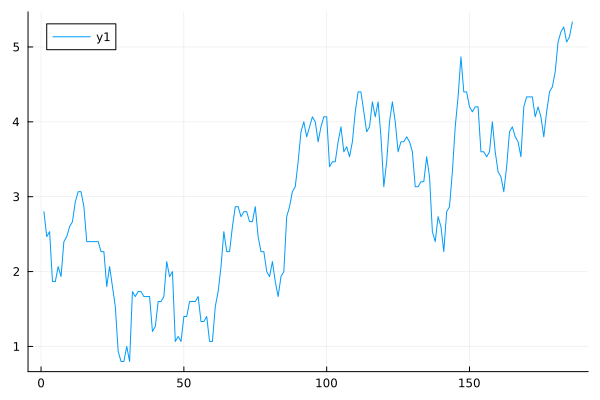

In [40]:
moving_average(opt.model.y, 15) |> plot

In [277]:
opt.model_optimizer

6-element Vector{Float64}:
  4.253579623503883
  0.11893742656692985
  0.13117390751312027
  3.653350089950678
 -1.8632123203559683
  1.0351431104433098

In [382]:
opt.model_optimizer

6-element Vector{Float64}:
  4.11916841419952
  0.125448107921958
  0.13754379964810431
  5.075924193043216
 -1.6490772236010975
  0.9886433311794273

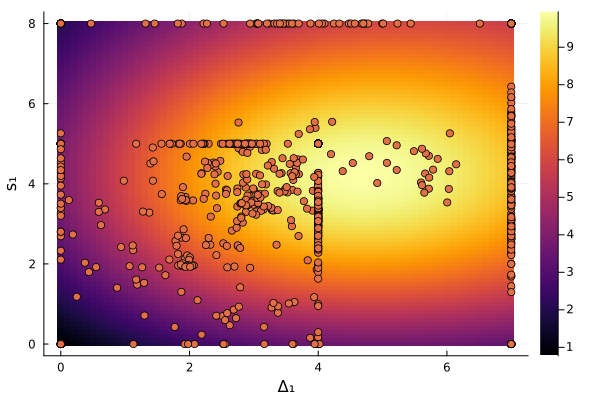

In [379]:
list1 = 0:0.1:8.0
list2 = 0:0.1:7.0

preds_mat = zeros(length(list1), length(list2))
points = zeros(6, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[1,1] = val1
        points[4,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel="Δ₁", ylabel="s₁")
scatter!(opt.model.x[4,:], opt.model.x[1,:], legend=nothing)

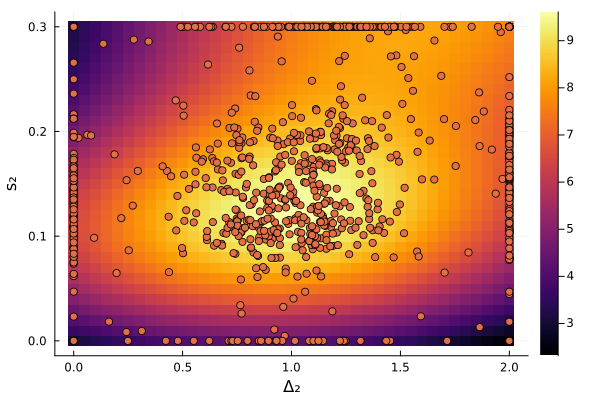

In [377]:
list1 = 0:0.01:0.3
list2 = 0:0.05:2

preds_mat = zeros(length(list1), length(list2))
points = zeros(6, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[3,1] = val1
        points[6,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel="Δ₂", ylabel="s₂")
scatter!(opt.model.x[6,:], opt.model.x[3,:], legend=nothing)

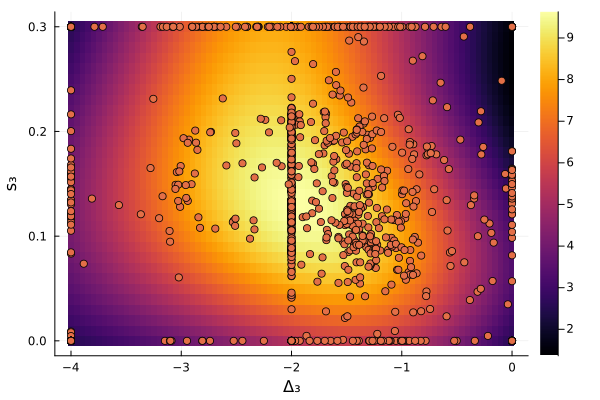

In [375]:
list1 = 0:0.01:0.3
list2 = reverse(-(0:0.05:4))

preds_mat = zeros(length(list1), length(list2))
points = zeros(6, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[2,1] = val1
        points[5,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list2, list1, preds_mat, xlabel="Δ₃", ylabel="s₃")
scatter!(opt.model.x[5,:], opt.model.x[2,:], legend=nothing)

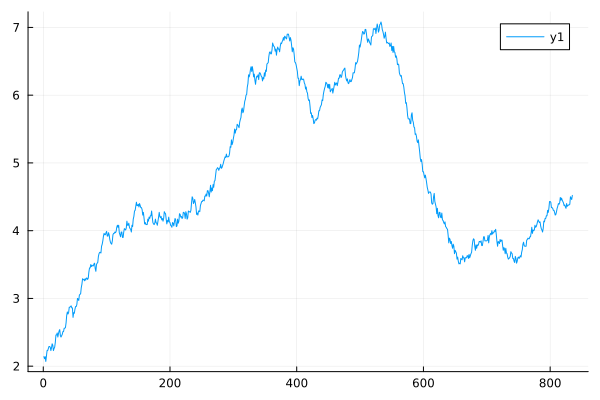

In [356]:
moving_average(opt.model.y, 100) |> plot

In [340]:
serialize("bayesian_optimization_save.jl", opt)

In [381]:
maxiterations!(opt, 1)
result = boptimize!(opt)

[ Info: 2023-10-04T02:26:51.587	iteration: 1101	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


[1, 5, 7, 8, 10, 12, 13, 14, 15, 16, 18, 20]
[9075.0, 5496.0, 7236.0, 4025.0, 8952.0, 2490.0, 9033.0, 9763.0, 2613.0, 8970.0, 4539.0, 9307.0, 9234.0, 8954.0, 9032.0, 9021.0, 7739.0, 9126.0, 6157.0, 8844.0]
12


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:             218s / 100.0%            102GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation        1     215s   98.7%    215s    102GiB   99.7%   102GiB
│  model hyperparamet...      1    2.42s    1.1%   2.42s    211MiB    0.2%   211MiB
│  acquisition                2    304ms    0.1%   152ms    152MiB    0.1%  75.9MiB
│  model update               1   1.92ms    0.0%  1.92ms    113KiB    0.0%   113KiB
└  ────────────────────────────────────────────────────────────────────────────────


(observed_optimum = 14.0, observed_optimizer = [1.9564208535597976, 0.18676918194206146, 0.0794701453110989, 1.8712087430521318, -1.6994581952803622, 0.9465753017859343], model_optimum = 10.067347030547719, model_optimizer = [4.11916841419952, 0.125448107921958, 0.13754379964810431, 5.075924193043216, -1.6490772236010975, 0.9886433311794273])

In [ ]:
opt

In [ ]:
maxiterations!(opt, 2000)
result = boptimize!(opt)

[ Info: 2023-10-04T09:13:39.080	iteration: 1108	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[3, 8, 16]
[1072.0, 20302.0, 22834.0, 517.0, 19789.0, 540.0, 1440.0, 22697.0, 4940.0, 15096.0, 3081.0, 18096.0, 10611.0, 1892.0, 15294.0, 22904.0, 1181.0, 18237.0, 9671.0, 4414.0]
3


[ Info: 2023-10-04T09:14:49.761	iteration: 1109	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 19, 20]
[8440.0, 1033.0, 7403.0, 7546.0, 7683.0, 7479.0, 9150.0, 7793.0, 8963.0, 7719.0, 5506.0, 8600.0, 6214.0, 7358.0, 7497.0, 7621.0, 3958.0, 6056.0, 7614.0, 7947.0]
11


[ Info: 2023-10-04T09:16:22.789	iteration: 1110	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[1, 3, 6, 7, 10, 11, 12, 13, 17]
[9055.0, 7197.0, 8951.0, 2089.0, 7260.0, 8901.0, 9063.0, 3152.0, 4991.0, 9288.0, 10204.0, 8877.0, 9338.0, 936.0, 6088.0, 6138.0, 9292.0, 6327.0, 8518.0, 7245.0]
9


[ Info: 2023-10-04T09:17:46.810	iteration: 1111	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[2, 4, 6, 9, 11, 12, 13, 15, 18, 19, 20]
[256.0, 7952.0, 137.0, 7715.0, 1661.0, 8132.0, 6164.0, 4716.0, 8271.0, 7730.0, 7955.0, 7738.0, 7911.0, 3106.0, 8366.0, 2473.0, 5292.0, 7589.0, 7948.0, 7859.0]
8

[ Info: 2023-10-04T09:19:13.077	iteration: 1112	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[711.0, 641.0, 630.0, 601.0, 682.0, 112.0, 595.0, 635.0, 374.0, 638.0, 623.0, 232.0, 681.0, 592.0, 621.0, 630.0, 633.0, 592.0, 576.0, 655.0]
0


[ Info: 2023-10-04T09:20:35.199	iteration: 1113	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[1, 2, 3, 4, 6, 8, 11, 12, 13, 15, 16, 17, 20]
[8105.0, 8094.0, 8186.0, 7896.0, 4398.0, 7318.0, 2842.0, 8059.0, 4202.0, 1608.0, 8626.0, 7811.0, 7795.0, 5590.0, 8239.0, 8212.0, 8083.0, 3096.0, 7396.0, 8088.0]
9


[ Info: 2023-10-04T09:22:03.447	iteration: 1114	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[3, 4, 8, 9, 10, 15, 16, 17, 19]
[1721.0, 2659.0, 9136.0, 9819.0, 483.0, 5413.0, 7770.0, 8871.0, 8682.0, 9533.0, 1846.0, 6568.0, 1993.0, 4623.0, 8869.0, 9148.0, 8983.0, 1725.0, 8626.0, 4856.0]
6


[ Info: 2023-10-04T09:23:27.773	iteration: 1115	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[1, 2, 6, 8, 10, 12, 13, 15, 17, 18, 19]
[8290.0, 8853.0, 5387.0, 6050.0, 7972.0, 8583.0, 1590.0, 8148.0, 179.0, 8139.0, 1692.0, 8351.0, 8546.0, 2588.0, 8069.0, 6009.0, 8581.0, 8373.0, 7808.0, 2520.0]
9


[ Info: 2023-10-04T09:24:51.388	iteration: 1116	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[2, 3, 7, 9, 11, 13, 14, 17]
[181.0, 9253.0, 10313.0, 7781.0, 3249.0, 9589.0, 10108.0, 4179.0, 10368.0, 643.0, 10177.0, 6579.0, 9646.0, 10481.0, 6581.0, 6807.0, 9734.0, 1012.0, 5166.0, 7806.0]
5


[ Info: 2023-10-04T09:26:13.890	iteration: 1117	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


[3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20]
[823.0, 2820.0, 5379.0, 6626.0, 5395.0, 5660.0, 5442.0, 3238.0, 5378.0, 13.0, 5019.0, 5331.0, 5835.0, 6522.0, 5358.0, 5589.0, 5638.0, 7052.0, 5803.0, 5750.0]
6


[ Info: 2023-10-04T09:27:49.239	iteration: 1118	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[2, 6, 7, 8, 10, 18, 19, 20]
[7802.0, 9232.0, 752.0, 2280.0, 7884.0, 10145.0, 9673.0, 9446.0, 5417.0, 9942.0, 5009.0, 6110.0, 8576.0, 1671.0, 5331.0, 9585.0, 3921.0, 9584.0, 10321.0, 10005.0]
6


[ Info: 2023-10-04T09:29:12.093	iteration: 1119	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[3, 13, 14, 20]
[2521.0, 3269.0, 6433.0, 263.0, 1179.0, 3465.0, 2751.0, 3710.0, 5655.0, 2568.0, 801.0, 2692.0, 5414.0, 6610.0, 4116.0, 5714.0, 2168.0, 4142.0, 2714.0, 6574.0]
0


[ Info: 2023-10-04T09:30:41.254	iteration: 1120	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[1, 7, 9, 11, 13, 18, 19, 20]
[12728.0, 5438.0, 5415.0, 11476.0, 3030.0, 12797.0, 13243.0, 10553.0, 14119.0, 4991.0, 13084.0, 3486.0, 12978.0, 5232.0, 7223.0, 278.0, 2555.0, 13754.0, 14419.0, 13534.0]
3


[ Info: 2023-10-04T09:31:59.156	iteration: 1121	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


[1, 2, 5, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20]
[5911.0, 6063.0, 144.0, 2649.0, 6235.0, 4840.0, 5048.0, 5798.0, 5953.0, 5724.0, 6024.0, 5967.0, 6461.0, 2911.0, 5962.0, 5554.0, 5468.0, 5374.0, 2633.0, 5571.0]
10


[ Info: 2023-10-04T09:33:33.688	iteration: 1122	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


[3, 5, 6, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19]
[2216.0, 394.0, 4055.0, 2816.0, 4202.0, 4452.0, 4083.0, 4201.0, 2375.0, 4104.0, 4145.0, 4066.0, 4491.0, 2104.0, 4366.0, 4285.0, 4088.0, 4221.0, 3987.0, 1699.0]
3


[ Info: 2023-10-04T09:35:20.064	iteration: 1123	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20Progress:  70%|█████████████████████████████            |  ETA: 0:00:31


[2, 4, 9, 13, 15, 18, 20]
[4950.0, 11009.0, 3574.0, 11843.0, 4360.0, 1882.0, 189.0, 1578.0, 11401.0, 9719.0, 2000.0, 2245.0, 11247.0, 4374.0, 11747.0, 108.0, 11150.0, 11891.0, 1794.0, 11523.0]
1


[ Info: 2023-10-04T09:36:42.827	iteration: 1124	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


[4, 5, 6, 7, 8, 9, 10, 14, 15, 18, 19, 20]
[4336.0, 3055.0, 2861.0, 6870.0, 7109.0, 7083.0, 5865.0, 7193.0, 6923.0, 7020.0, 4675.0, 4790.0, 1059.0, 7134.0, 7147.0, 2959.0, 5968.0, 6894.0, 6857.0, 6430.0]
1


[ Info: 2023-10-04T09:38:37.267	iteration: 1125	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


[1, 2, 3, 4, 6, 7, 8, 9, 13, 14, 16, 17, 20]
[5922.0, 5825.0, 6683.0, 6274.0, 5026.0, 5971.0, 6257.0, 6515.0, 6222.0, 4270.0, 3135.0, 5105.0, 6073.0, 6791.0, 3664.0, 6610.0, 6024.0, 5595.0, 2912.0, 6013.0]
11

[ Info: 2023-10-04T09:40:26.734	iteration: 1126	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 3, 4, 5, 8, 10, 12, 13, 14, 18, 20]
[1394.0, 1311.0, 1396.0, 1556.0, 1365.0, 913.0, 532.0, 1477.0, 161.0, 1399.0, 679.0, 1468.0, 1416.0, 1521.0, 927.0, 1226.0, 1209.0, 1435.0, 925.0, 1364.0]
1


[ Info: 2023-10-04T09:41:59.299	iteration: 1127	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


[1, 2, 4, 5, 6, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20]
[6395.0, 6612.0, 5657.0, 7206.0, 6314.0, 6440.0, 1161.0, 4190.0, 6392.0, 6767.0, 6670.0, 6798.0, 5465.0, 7109.0, 3492.0, 6527.0, 6541.0, 6824.0, 6591.0, 6922.0]
10


[ Info: 2023-10-04T09:43:36.648	iteration: 1128	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


[2, 5, 8, 10, 13, 14, 15, 16, 17]
[6514.0, 8281.0, 2213.0, 979.0, 6981.0, 2601.0, 1193.0, 7324.0, 5035.0, 7779.0, 5226.0, 4276.0, 7146.0, 7715.0, 7643.0, 8186.0, 7501.0, 5598.0, 3481.0, 1940.0]
4


[ Info: 2023-10-04T09:45:05.860	iteration: 1129	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 18, 20]
[6701.0, 6623.0, 6631.0, 7298.0, 6234.0, 6684.0, 6844.0, 6464.0, 6784.0, 6691.0, 244.0, 6635.0, 6945.0, 7177.0, 3373.0, 6803.0, 6133.0, 6683.0, 2855.0, 6947.0]
11


[ Info: 2023-10-04T09:46:34.238	iteration: 1130	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[1, 2, 3, 4, 7, 8, 9, 10, 12, 14, 15, 16, 17, 20]
[6937.0, 7438.0, 6716.0, 6378.0, 4721.0, 2746.0, 6304.0, 6270.0, 6815.0, 6653.0, 58.0, 6172.0, 2645.0, 6849.0, 6678.0, 7382.0, 6313.0, 1589.0, 451.0, 6765.0]
11


[ Info: 2023-10-04T09:47:57.137	iteration: 1131	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


[5, 6, 7, 9, 10, 11, 14, 15, 16, 18]
[3777.0, 2515.0, 2077.0, 3505.0, 5923.0, 7402.0, 6429.0, 1418.0, 6820.0, 5712.0, 6841.0, 1703.0, 1929.0, 6403.0, 4966.0, 7275.0, 3669.0, 5303.0, 746.0, 5949.0]
0


[ Info: 2023-10-04T09:49:26.938	iteration: 1132	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
[6674.0, 6613.0, 7053.0, 7474.0, 3758.0, 7053.0, 6698.0, 6873.0, 7013.0, 2018.0, 6761.0, 6813.0, 6960.0, 7300.0, 6933.0, 7265.0, 7002.0, 6800.0, 5409.0, 732.0]
12

[ Info: 2023-10-04T09:50:59.077	iteration: 1133	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


[2, 4, 5, 7, 8, 9, 12, 13, 20]
[821.0, 1140.0, 542.0, 1090.0, 990.0, 1034.0, 1131.0, 1138.0, 1186.0, 988.0, 605.0, 1132.0, 1089.0, 901.0, 747.0, 725.0, 716.0, 987.0, 990.0, 1011.0]
0


[ Info: 2023-10-04T09:53:08.429	iteration: 1134	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 19, 20]
[5101.0, 5102.0, 4348.0, 4440.0, 4557.0, 4593.0, 6515.0, 4605.0, 5128.0, 4592.0, 4922.0, 832.0, 4271.0, 4580.0, 308.0, 4754.0, 4403.0, 2144.0, 4259.0, 5761.0]
2


[ Info: 2023-10-04T09:54:55.143	iteration: 1135	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


[1, 2, 6, 7, 9, 11, 17, 18, 20]
[7058.0, 6735.0, 431.0, 6175.0, 2383.0, 6939.0, 7295.0, 6042.0, 6730.0, 6830.0, 7137.0, 3314.0, 1505.0, 4566.0, 1221.0, 388.0, 7364.0, 7457.0, 3713.0, 7345.0]
8


[ Info: 2023-10-04T09:56:09.528	iteration: 1136	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 20]
[5115.0, 5555.0, 5285.0, 5734.0, 5160.0, 5660.0, 5056.0, 5191.0, 5243.0, 5130.0, 5313.0, 5290.0, 1842.0, 4982.0, 3559.0, 1125.0, 5015.0, 5021.0, 2828.0, 5150.0]
9


[ Info: 2023-10-04T09:57:42.164	iteration: 1137	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[2, 3, 5, 9, 11, 12, 15, 17, 18, 20]
[7900.0, 8535.0, 8995.0, 3757.0, 8565.0, 2215.0, 930.0, 7979.0, 8763.0, 5557.0, 9465.0, 9436.0, 5488.0, 355.0, 9288.0, 7374.0, 9622.0, 9537.0, 2302.0, 8990.0]
6


[ Info: 2023-10-04T09:59:06.553	iteration: 1138	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19]
[4974.0, 4799.0, 5330.0, 5867.0, 4665.0, 4894.0, 4786.0, 4716.0, 4774.0, 5136.0, 3121.0, 4920.0, 4920.0, 5018.0, 2406.0, 4994.0, 4995.0, 5538.0, 4962.0, 564.0]
8


[ Info: 2023-10-04T10:00:44.271	iteration: 1139	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[1, 4, 5, 6, 9, 10, 11, 12, 14, 15, 18, 19, 20]
[6541.0, 89.0, 5680.0, 6054.0, 6829.0, 6271.0, 6460.0, 2350.0, 6929.0, 6149.0, 6703.0, 6398.0, 5742.0, 6440.0, 6457.0, 2895.0, 4679.0, 6189.0, 6583.0, 6832.0]
6


[ Info: 2023-10-04T10:02:11.010	iteration: 1140	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


[5, 8, 10, 12, 13]
[584.0, 3585.0, 11891.0, 422.0, 13661.0, 9515.0, 6238.0, 13054.0, 2384.0, 13307.0, 2210.0, 13166.0, 13059.0, 8285.0, 5074.0, 262.0, 2159.0, 12537.0, 1437.0, 2044.0]
3


[ Info: 2023-10-04T10:03:24.729	iteration: 1141	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


[1, 2, 3, 4, 5, 6, 8, 10, 12, 17, 18, 19, 20]
[6186.0, 6398.0, 5719.0, 5993.0, 6454.0, 5940.0, 385.0, 5851.0, 732.0, 6090.0, 3213.0, 6505.0, 98.0, 1092.0, 3942.0, 4169.0, 6240.0, 6065.0, 5953.0, 6237.0]
9


[ Info: 2023-10-04T10:04:44.967	iteration: 1142	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


[3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 19]
[2256.0, 4853.0, 5643.0, 8222.0, 6084.0, 6134.0, 1539.0, 5713.0, 6233.0, 6848.0, 7084.0, 5991.0, 6350.0, 6242.0, 34.0, 1815.0, 5817.0, 2071.0, 8890.0, 971.0]
6


[ Info: 2023-10-04T10:06:31.322	iteration: 1143	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[2, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 19, 20]
[311.0, 6141.0, 2207.0, 6715.0, 6137.0, 6491.0, 6272.0, 5922.0, 6481.0, 3633.0, 6460.0, 5862.0, 1076.0, 3465.0, 6077.0, 5875.0, 6262.0, 1043.0, 5865.0, 6414.0]
10


[ Info: 2023-10-04T10:08:00.228	iteration: 1144	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20]
[1135.0, 5184.0, 1484.0, 3861.0, 5149.0, 5636.0, 5629.0, 5657.0, 5590.0, 5243.0, 5521.0, 5195.0, 5252.0, 2567.0, 1283.0, 199.0, 6146.0, 5614.0, 5314.0, 5208.0]
10

[ Info: 2023-10-04T10:09:29.015	iteration: 1145	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


[2, 5, 10, 12, 13, 15, 17, 19, 20]
[4251.0, 8446.0, 4507.0, 4607.0, 8262.0, 5634.0, 3501.0, 432.0, 6488.0, 8748.0, 2797.0, 8344.0, 8167.0, 8359.0, 8709.0, 608.0, 8320.0, 8145.0, 8417.0, 8406.0]
8


[ Info: 2023-10-04T10:10:49.203	iteration: 1146	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 16, 17, 20]
[5499.0, 6181.0, 5371.0, 5375.0, 5545.0, 5672.0, 5781.0, 1243.0, 2152.0, 5197.0, 5639.0, 2817.0, 5572.0, 4653.0, 5431.0, 5374.0, 5694.0, 442.0, 958.0, 6211.0]
10


[ Info: 2023-10-04T10:12:22.256	iteration: 1147	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


[4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 19, 20]
[6858.0, 1529.0, 2358.0, 8301.0, 7991.0, 8295.0, 8285.0, 8113.0, 8315.0, 8132.0, 8199.0, 2009.0, 1335.0, 8155.0, 8637.0, 8149.0, 8472.0, 7479.0, 8490.0, 8416.0]
9


[ Info: 2023-10-04T10:13:50.269	iteration: 1148	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


[2, 3, 4, 6, 7, 8, 9, 10, 14, 16, 19, 20]
[200.0, 583.0, 562.0, 635.0, 181.0, 584.0, 586.0, 548.0, 608.0, 562.0, 233.0, 114.0, 177.0, 596.0, 427.0, 502.0, 273.0, 109.0, 601.0, 597.0]
0


[ Info: 2023-10-04T10:15:01.106	iteration: 1149	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[1, 2, 5, 7, 9, 11, 12, 14, 16, 17, 18]
[5780.0, 5662.0, 2574.0, 2466.0, 5631.0, 457.0, 5364.0, 2058.0, 5557.0, 4613.0, 5777.0, 5681.0, 4645.0, 5510.0, 5076.0, 5672.0, 5419.0, 5580.0, 3743.0, 618.0]
11


[ Info: 2023-10-04T10:16:24.868	iteration: 1150	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


[1, 2, 4, 6, 7, 9, 10, 13, 14, 15, 17, 19, 20]
[5348.0, 5633.0, 4212.0, 5980.0, 5856.0, 5647.0, 6091.0, 4752.0, 5971.0, 6137.0, 3886.0, 786.0, 5907.0, 5873.0, 6216.0, 5851.0, 5916.0, 5385.0, 5674.0, 5581.0]
7


[ Info: 2023-10-04T10:17:55.496	iteration: 1151	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]
[5751.0, 5012.0, 5208.0, 5113.0, 5368.0, 5022.0, 4633.0, 5315.0, 4993.0, 5018.0, 4856.0, 4770.0, 4732.0, 5001.0, 4857.0, 1005.0, 5062.0, 4955.0, 5143.0, 1058.0]
9


[ Info: 2023-10-04T10:19:40.059	iteration: 1152	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 19, 20]
[5933.0, 2744.0, 6020.0, 6787.0, 6675.0, 5568.0, 5736.0, 6094.0, 6075.0, 5845.0, 6282.0, 2430.0, 4234.0, 5737.0, 6088.0, 968.0, 752.0, 1332.0, 5828.0, 5977.0]
8


[ Info: 2023-10-04T10:21:08.542	iteration: 1153	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[1, 2, 3, 4, 9, 12, 14, 15, 17, 18, 19]
[5740.0, 5869.0, 6341.0, 5782.0, 2562.0, 818.0, 5815.0, 1213.0, 6377.0, 998.0, 3091.0, 6216.0, 884.0, 6080.0, 5872.0, 1814.0, 7049.0, 6286.0, 6688.0, 2004.0]
7


[ Info: 2023-10-04T10:22:32.447	iteration: 1154	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


[1, 2, 9, 13, 15, 16, 20]
[8931.0, 8830.0, 7871.0, 1269.0, 1203.0, 3312.0, 6655.0, 4299.0, 8864.0, 2325.0, 3248.0, 3214.0, 9222.0, 2511.0, 9770.0, 8604.0, 8413.0, 9.0, 3935.0, 9171.0]
5

[ Info: 2023-10-04T10:23:48.160	iteration: 1155	current optimum: 14.0


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


[2, 3, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20]
[1889.0, 5627.0, 5500.0, 3878.0, 5974.0, 633.0, 6101.0, 6284.0, 5929.0, 5509.0, 5785.0, 3842.0, 400.0, 5996.0, 6303.0, 6252.0, 5550.0, 5755.0, 6619.0, 5737.0]
9


[ Info: 2023-10-04T10:25:24.859	iteration: 1156	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


[1, 5, 7, 8, 9, 11, 12, 14, 16, 17, 18, 20]
[4942.0, 2029.0, 3022.0, 2041.0, 5261.0, 3356.0, 5224.0, 5070.0, 5257.0, 1265.0, 5206.0, 5019.0, 4559.0, 5045.0, 1943.0, 5089.0, 4955.0, 5067.0, 1491.0, 5116.0]
5


[ Info: 2023-10-04T10:26:46.973	iteration: 1157	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 20]
[5377.0, 4898.0, 5285.0, 4975.0, 5100.0, 4713.0, 5214.0, 4993.0, 5171.0, 5141.0, 5103.0, 2463.0, 4919.0, 5250.0, 5039.0, 29.0, 4987.0, 3620.0, 4899.0, 5239.0]
5


[ Info: 2023-10-04T10:28:23.048	iteration: 1158	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[3, 5, 7, 8, 10, 14, 16, 17, 19, 20]
[2363.0, 3378.0, 8388.0, 6905.0, 7745.0, 1697.0, 7851.0, 7818.0, 4574.0, 8324.0, 7314.0, 7465.0, 6206.0, 7557.0, 3902.0, 7871.0, 7520.0, 5235.0, 8165.0, 7997.0]
10


[ Info: 2023-10-04T10:29:47.272	iteration: 1159	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


[2, 3, 6, 7, 9, 10, 13, 20]
[5054.0, 6499.0, 6757.0, 1102.0, 3101.0, 6774.0, 5727.0, 3875.0, 6225.0, 6334.0, 2420.0, 3464.0, 6371.0, 7064.0, 2332.0, 5829.0, 709.0, 1255.0, 3601.0, 6536.0]
6


[ Info: 2023-10-04T10:31:18.375	iteration: 1160	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[1, 3, 5, 8, 9, 10, 12, 13, 16, 19, 20]
[8877.0, 4745.0, 8347.0, 3394.0, 8420.0, 1524.0, 4681.0, 8006.0, 8113.0, 8612.0, 6885.0, 8346.0, 8280.0, 410.0, 2744.0, 8857.0, 2565.0, 1561.0, 8593.0, 8395.0]
8


[ Info: 2023-10-04T10:32:36.851	iteration: 1161	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[1, 2, 3, 7, 10, 11, 12, 14, 18, 19, 20]
[7993.0, 7327.0, 8059.0, 7297.0, 1144.0, 4993.0, 7453.0, 1388.0, 1021.0, 7919.0, 9483.0, 7671.0, 3550.0, 8686.0, 6730.0, 7056.0, 1580.0, 9762.0, 8064.0, 7631.0]
10


[ Info: 2023-10-04T10:34:03.878	iteration: 1162	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


[5, 8]
[11653.0, 1683.0, 11030.0, 23809.0, 25634.0, 7163.0, 2834.0, 26603.0, 18237.0, 4917.0, 1184.0, 1070.0, 22670.0, 1329.0, 11597.0, 4263.0, 3866.0, 6103.0, 9799.0, 11145.0]
1


[ Info: 2023-10-04T10:35:04.491	iteration: 1163	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


[2, 5, 6, 7, 10, 11, 16, 19, 20]
[4682.0, 7872.0, 2024.0, 1660.0, 8454.0, 7945.0, 8314.0, 7259.0, 1839.0, 7694.0, 7587.0, 7629.0, 1708.0, 265.0, 1909.0, 8055.0, 6582.0, 1233.0, 8213.0, 7949.0]
8


[ Info: 2023-10-04T10:36:30.467	iteration: 1164	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


[7, 10, 16, 17]
[117.0, 200.0, 117.0, 70.0, 120.0, 157.0, 235.0, 139.0, 84.0, 199.0, 214.0, 125.0, 126.0, 148.0, 234.0, 212.0, 221.0, 116.0, 71.0, 146.0]
0


[ Info: 2023-10-04T10:37:47.093	iteration: 1165	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19]
[5375.0, 5656.0, 5387.0, 5668.0, 1059.0, 5718.0, 5572.0, 5454.0, 5282.0, 5555.0, 5229.0, 3020.0, 1058.0, 4124.0, 1741.0, 5252.0, 5675.0, 5518.0, 5308.0, 4610.0]
2


[ Info: 2023-10-04T10:39:48.509	iteration: 1166	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[2, 3, 5, 6, 8, 9, 10, 11, 17, 20]
[1357.0, 6376.0, 6537.0, 952.0, 6443.0, 6758.0, 6643.0, 6596.0, 6755.0, 6378.0, 6916.0, 603.0, 5805.0, 5077.0, 4478.0, 4631.0, 6632.0, 1313.0, 4546.0, 6574.0]
6


[ Info: 2023-10-04T10:41:12.267	iteration: 1167	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


[3, 7, 9, 10, 11, 16]
[11727.0, 7727.0, 20179.0, 7126.0, 19891.0, 18101.0, 17882.0, 6619.0, 17874.0, 18679.0, 19947.0, 3433.0, 7313.0, 5342.0, 18064.0, 16812.0, 7066.0, 4146.0, 2405.0, 15703.0]
0


[ Info: 2023-10-04T10:42:29.706	iteration: 1168	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20]
[5817.0, 6589.0, 3249.0, 5678.0, 5932.0, 6108.0, 6151.0, 1272.0, 5769.0, 5832.0, 5927.0, 5943.0, 4137.0, 5652.0, 6916.0, 4086.0, 5787.0, 5664.0, 6010.0, 5904.0]
11


[ Info: 2023-10-04T10:44:04.905	iteration: 1169	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[1, 2, 3, 5, 6, 9, 11, 12, 13, 14, 16, 19]
[4814.0, 5098.0, 5005.0, 3448.0, 5138.0, 5445.0, 3902.0, 2145.0, 4957.0, 728.0, 5086.0, 5163.0, 5377.0, 5003.0, 3203.0, 5692.0, 126.0, 1588.0, 4998.0, 670.0]
3


[ Info: 2023-10-04T10:45:29.141	iteration: 1170	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


[2, 5, 6, 9, 10, 11, 13, 15, 17, 19]
[9242.0, 8873.0, 4991.0, 6880.0, 9871.0, 9678.0, 7731.0, 4820.0, 9080.0, 9544.0, 8751.0, 5035.0, 8910.0, 2554.0, 9417.0, 3526.0, 9006.0, 755.0, 9215.0, 497.0]
9


[ Info: 2023-10-04T10:46:57.157	iteration: 1171	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


[2, 3, 8, 11, 13, 14, 15, 16, 17, 19, 20]
[2529.0, 6991.0, 8451.0, 1269.0, 3427.0, 7715.0, 2967.0, 7479.0, 1935.0, 1409.0, 7131.0, 1919.0, 7276.0, 6500.0, 6999.0, 6936.0, 6969.0, 7417.0, 7583.0, 9379.0]
6


[ Info: 2023-10-04T10:48:32.479	iteration: 1172	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


[1, 2, 3, 6, 8, 9, 10, 11, 13, 16, 19]
[6925.0, 6571.0, 6172.0, 2442.0, 5870.0, 6334.0, 5269.0, 6271.0, 6732.0, 6122.0, 6362.0, 2934.0, 6480.0, 1192.0, 2713.0, 6686.0, 2924.0, 6219.0, 6282.0, 1335.0]
6


[ Info: 2023-10-04T10:50:07.094	iteration: 1173	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


[1, 3, 5, 6, 9, 11, 13, 16, 18, 20]
[8699.0, 2683.0, 9309.0, 1145.0, 9402.0, 9568.0, 4856.0, 6144.0, 9396.0, 961.0, 8954.0, 4963.0, 9029.0, 8513.0, 6568.0, 9087.0, 7723.0, 9111.0, 620.0, 9291.0]
8


[ Info: 2023-10-04T10:51:32.783	iteration: 1174	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[3, 4, 6, 7, 8, 10, 11, 12, 13, 16, 20]
[949.0, 6785.0, 8376.0, 8345.0, 3901.0, 8603.0, 9691.0, 8355.0, 2368.0, 8714.0, 8383.0, 8058.0, 8835.0, 6968.0, 2568.0, 8998.0, 3889.0, 2945.0, 1844.0, 8026.0]
6


[ Info: 2023-10-04T10:52:57.509	iteration: 1175	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[2, 5, 8, 10, 13, 14, 17, 18, 19, 20]
[3999.0, 9891.0, 3339.0, 9464.0, 9980.0, 8117.0, 7482.0, 9949.0, 3592.0, 10026.0, 1464.0, 1077.0, 10098.0, 10096.0, 3708.0, 2157.0, 9846.0, 10088.0, 9749.0, 9731.0]
7


[ Info: 2023-10-04T10:54:20.332	iteration: 1176	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


[1, 4, 5, 7, 10, 11, 12, 15, 16, 17, 18]
[7224.0, 994.0, 3286.0, 7497.0, 7606.0, 2694.0, 7216.0, 6914.0, 2095.0, 7685.0, 7488.0, 7754.0, 2154.0, 1717.0, 7597.0, 7241.0, 7645.0, 7699.0, 7308.0, 2723.0]
9


[ Info: 2023-10-04T10:55:42.366	iteration: 1177	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 19]
[2082.0, 10462.0, 9744.0, 9659.0, 9810.0, 9525.0, 9484.0, 9667.0, 10092.0, 9353.0, 5745.0, 9513.0, 9434.0, 634.0, 9609.0, 4909.0, 2516.0, 8250.0, 9931.0, 1193.0]
8


[ Info: 2023-10-04T10:57:11.646	iteration: 1178	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


[1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19]
[7973.0, 6374.0, 7284.0, 7379.0, 7798.0, 5888.0, 7232.0, 7228.0, 7901.0, 7351.0, 7398.0, 7609.0, 1550.0, 9768.0, 7825.0, 1032.0, 7503.0, 7235.0, 7512.0, 5429.0]
10


[ Info: 2023-10-04T10:58:54.399	iteration: 1179	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


[1, 2, 3, 7, 8, 9, 12, 14, 17, 19, 20]
[7229.0, 6946.0, 6725.0, 2171.0, 1243.0, 5744.0, 6878.0, 6671.0, 6938.0, 2051.0, 2296.0, 6686.0, 5409.0, 6974.0, 141.0, 4196.0, 6724.0, 1415.0, 7058.0, 8205.0]
7


[ Info: 2023-10-04T11:00:20.742	iteration: 1180	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15, 16, 19]
[7414.0, 7261.0, 7500.0, 7248.0, 7398.0, 6958.0, 4211.0, 8015.0, 6554.0, 4593.0, 6672.0, 147.0, 7010.0, 3945.0, 6352.0, 7454.0, 5525.0, 4041.0, 6729.0, 2772.0]
7


[ Info: 2023-10-04T11:01:45.384	iteration: 1181	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 3, 5, 7, 9, 10, 11, 12, 14, 15, 18, 19, 20]
[8283.0, 8236.0, 8343.0, 7627.0, 8301.0, 6781.0, 8406.0, 4575.0, 8254.0, 8312.0, 8503.0, 8199.0, 241.0, 8070.0, 8470.0, 3253.0, 8655.0, 7986.0, 8045.0, 8560.0]
12


[ Info: 2023-10-04T11:03:18.412	iteration: 1182	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[1, 2, 3, 4, 5, 6, 7, 11, 17, 18, 20]
[6608.0, 7141.0, 6696.0, 7148.0, 6742.0, 6829.0, 6968.0, 3295.0, 5075.0, 5745.0, 7122.0, 3213.0, 3972.0, 2406.0, 2385.0, 1364.0, 6725.0, 7207.0, 3092.0, 6856.0]
8


[ Info: 2023-10-04T11:04:42.958	iteration: 1183	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


[2, 4, 5, 13]
[4210.0, 25888.0, 19435.0, 25530.0, 27596.0, 1125.0, 12758.0, 1251.0, 6947.0, 5529.0, 1604.0, 4126.0, 21326.0, 2550.0, 22003.0, 1902.0, 26191.0, 2412.0, 13216.0, 12725.0]
1


[ Info: 2023-10-04T11:05:55.378	iteration: 1184	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


[2, 3, 4, 5, 6, 13, 16]
[7211.0, 8769.0, 9183.0, 8818.0, 8851.0, 8914.0, 8996.0, 2905.0, 8632.0, 5438.0, 4019.0, 7616.0, 8923.0, 3065.0, 3308.0, 8760.0, 6403.0, 5184.0, 7626.0, 8763.0]
4


[ Info: 2023-10-04T11:07:23.005	iteration: 1185	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


[1, 2, 7, 8, 9, 12, 13, 14, 16]
[11309.0, 11699.0, 6468.0, 3839.0, 3710.0, 1280.0, 11507.0, 10568.0, 11498.0, 8604.0, 7685.0, 11412.0, 11541.0, 11706.0, 3011.0, 12185.0, 10925.0, 5132.0, 3506.0, 140.0]
8


[ Info: 2023-10-04T11:08:46.425	iteration: 1186	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


[1, 4, 5, 6, 11, 14, 15, 16, 19, 20]
[8628.0, 6530.0, 2919.0, 9439.0, 8089.0, 8001.0, 4968.0, 2397.0, 55.0, 6816.0, 7906.0, 2340.0, 6608.0, 8629.0, 7792.0, 8404.0, 305.0, 5720.0, 7837.0, 8169.0]
8


[ Info: 2023-10-04T11:10:22.597	iteration: 1187	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[5, 6, 9, 11, 12, 13, 14, 15, 18, 19, 20]
[7027.0, 4208.0, 222.0, 2495.0, 8172.0, 8727.0, 8813.0, 5982.0, 8564.0, 6560.0, 8585.0, 9038.0, 8987.0, 9649.0, 8949.0, 6276.0, 3125.0, 8324.0, 8280.0, 8695.0]
7


[ Info: 2023-10-04T11:11:55.782	iteration: 1188	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


[1, 3, 4, 5, 6, 8, 10, 11, 13, 14, 19, 20]
[2841.0, 998.0, 3083.0, 3405.0, 2766.0, 2767.0, 516.0, 3208.0, 1242.0, 3110.0, 2621.0, 1746.0, 3100.0, 2875.0, 1343.0, 1599.0, 3084.0, 2334.0, 2799.0, 3037.0]
0


[ Info: 2023-10-04T11:13:48.719	iteration: 1189	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


[2, 6, 14, 16, 17, 19, 20]
[6899.0, 16201.0, 404.0, 9365.0, 914.0, 14650.0, 864.0, 7483.0, 2987.0, 13428.0, 10915.0, 12976.0, 9268.0, 16588.0, 13776.0, 15445.0, 15486.0, 1667.0, 15951.0, 16252.0]
6


[ Info: 2023-10-04T11:15:09.092	iteration: 1190	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


[3, 6, 8, 10, 12, 15, 16, 17, 20]
[2183.0, 7109.0, 9122.0, 7142.0, 5359.0, 9983.0, 8264.0, 9615.0, 1694.0, 10458.0, 2565.0, 9407.0, 3436.0, 8527.0, 10141.0, 9458.0, 9641.0, 8688.0, 2096.0, 9117.0]
3


[ Info: 2023-10-04T11:16:38.815	iteration: 1191	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


[2, 4, 5, 6, 9, 11, 12, 16, 17, 19]
[3951.0, 6927.0, 475.0, 6700.0, 6992.0, 7503.0, 4485.0, 220.0, 7430.0, 2073.0, 7225.0, 6794.0, 1835.0, 5969.0, 6232.0, 6603.0, 7208.0, 5140.0, 6644.0, 4486.0]
2


[ Info: 2023-10-04T11:18:14.273	iteration: 1192	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


[2, 4, 5, 6, 7, 9, 11, 12, 14, 16, 17, 19, 20]
[3575.0, 8078.0, 3473.0, 8248.0, 8569.0, 8812.0, 8655.0, 633.0, 8428.0, 72.0, 8127.0, 8791.0, 4917.0, 8593.0, 6115.0, 8391.0, 8230.0, 7826.0, 8307.0, 8320.0]
10


[ Info: 2023-10-04T11:19:37.484	iteration: 1193	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 4, 5, 7, 9, 10, 15, 17]
[10062.0, 3677.0, 4972.0, 10044.0, 10010.0, 7299.0, 8978.0, 2910.0, 9145.0, 9896.0, 2328.0, 553.0, 7371.0, 1651.0, 9304.0, 10087.0, 9758.0, 7693.0, 7052.0, 4133.0]
2


[ Info: 2023-10-04T11:21:10.566	iteration: 1194	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


[1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 18, 20]
[10340.0, 10045.0, 9722.0, 10348.0, 10181.0, 5862.0, 5043.0, 10307.0, 11964.0, 1769.0, 10160.0, 11601.0, 10292.0, 1741.0, 3154.0, 3454.0, 47.0, 9787.0, 1584.0, 9720.0]
7


[ Info: 2023-10-04T11:22:43.472	iteration: 1195	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


[2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 19]
[6951.0, 8245.0, 8118.0, 8105.0, 9505.0, 8643.0, 9390.0, 2646.0, 2215.0, 8659.0, 8200.0, 8148.0, 8612.0, 8608.0, 8028.0, 3955.0, 3159.0, 7727.0, 8347.0, 4865.0]
10


[ Info: 2023-10-04T11:24:07.727	iteration: 1196	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


[2, 3, 4, 8, 10, 12, 14, 16, 17, 18, 19, 20]
[3928.0, 6692.0, 6600.0, 6204.0, 1514.0, 22.0, 190.0, 6403.0, 5188.0, 6679.0, 4592.0, 6525.0, 3470.0, 6447.0, 4714.0, 6746.0, 6731.0, 6730.0, 6435.0, 6348.0]
1


[ Info: 2023-10-04T11:25:56.721	iteration: 1197	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


[4, 6, 8, 11, 14, 15, 17, 18]
[7044.0, 2483.0, 2453.0, 8696.0, 4123.0, 8596.0, 3968.0, 8556.0, 2438.0, 4579.0, 8632.0, 5923.0, 2770.0, 8742.0, 8403.0, 560.0, 8565.0, 8022.0, 3880.0, 303.0]
6


[ Info: 2023-10-04T11:27:11.425	iteration: 1198	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


[4, 6, 7, 10, 12, 13, 14, 15, 16, 20]
[3280.0, 7874.0, 3719.0, 11459.0, 2355.0, 10487.0, 10960.0, 10085.0, 5519.0, 11096.0, 7106.0, 11242.0, 11301.0, 10972.0, 11058.0, 10869.0, 4032.0, 739.0, 5205.0, 11104.0]
7


[ Info: 2023-10-04T11:28:37.569	iteration: 1199	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


[1, 3, 6, 9, 12, 15, 17, 19]
[6804.0, 483.0, 6673.0, 1736.0, 5456.0, 7148.0, 5277.0, 4514.0, 6535.0, 945.0, 2445.0, 6604.0, 5388.0, 3926.0, 6347.0, 2250.0, 6436.0, 4652.0, 6436.0, 3843.0]
4


[ Info: 2023-10-04T11:30:09.625	iteration: 1200	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


[1, 3, 4, 6, 8, 11, 14, 16, 18]
[8289.0, 8145.0, 8750.0, 8558.0, 7793.0, 9112.0, 86.0, 9046.0, 2965.0, 1594.0, 8579.0, 3389.0, 4434.0, 8570.0, 2169.0, 8904.0, 959.0, 9822.0, 2406.0, 1927.0]
9


[ Info: 2023-10-04T11:31:29.127	iteration: 1201	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[3, 8, 11, 13, 18]
[7700.0, 16886.0, 25218.0, 10658.0, 12157.0, 2662.0, 22238.0, 26089.0, 5400.0, 2040.0, 25584.0, 12201.0, 26191.0, 1894.0, 7030.0, 20407.0, 7512.0, 26426.0, 8592.0, 21928.0]
5


[ Info: 2023-10-04T11:32:39.023	iteration: 1202	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


[6, 11, 15, 16]
[12627.0, 13726.0, 5202.0, 9653.0, 7421.0, 17777.0, 11778.0, 5586.0, 3995.0, 6815.0, 16297.0, 15019.0, 9152.0, 18711.0, 20402.0, 16721.0, 9003.0, 17137.0, 2157.0, 14144.0]
2


[ Info: 2023-10-04T11:33:48.820	iteration: 1203	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[4, 10, 11, 12, 13, 14, 17, 18]
[4438.0, 5268.0, 2259.0, 7623.0, 2969.0, 1890.0, 1826.0, 1120.0, 5459.0, 7532.0, 7604.0, 7627.0, 7762.0, 7324.0, 1244.0, 8080.0, 7472.0, 7745.0, 4568.0, 4670.0]
4


[ Info: 2023-10-04T11:35:17.449	iteration: 1204	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
[8834.0, 98.0, 7207.0, 9027.0, 8296.0, 9327.0, 8972.0, 8397.0, 9251.0, 9579.0, 8881.0, 8509.0, 8729.0, 9303.0, 8601.0, 8456.0, 4679.0, 8636.0, 5733.0, 4138.0]
11


[ Info: 2023-10-04T11:36:46.042	iteration: 1205	current optimum: 14.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[5, 13]
[6222.0, 738.0, 13722.0, 24361.0, 30541.0, 21510.0, 2759.0, 24512.0, 14158.0, 3153.0, 8270.0, 15114.0, 29076.0, 11999.0, 6943.0, 4066.0, 2085.0, 5521.0, 16514.0, 16329.0]
2


[ Info: 2023-10-04T11:37:45.985	iteration: 1206	current optimum: 14.0


[1, 3, 5, 6, 7, 8, 14, 15, 16, 17]
[8898.0, 6662.0, 8859.0, 8381.0, 9110.0, 9133.0, 9282.0, 8579.0, 4612.0, 8927.0, 6685.0, 113.0, 1491.0, 8588.0, 8945.0, 9360.0, 8741.0, 362.0, 5927.0, 59.0]
9
[1, 3, 4, 6, 8, 12, 14, 15, 16, 17, 18, 19]
[11300.0, 7535.0, 10612.0, 11300.0, 8732.0, 11043.0, 4158.0, 10922.0, 5088.0, 8532.0, 11174.0, 11099.0, 1762.0, 11034.0, 12357.0, 11021.0, 10921.0, 11058.0, 11043.0, 791.0]
11
[1, 3, 5, 6, 7, 10, 12, 14, 15, 17, 18, 19, 20]
[10212.0, 5853.0, 10076.0, 4601.0, 10442.0, 10147.0, 9773.0, 1338.0, 8714.0, 10653.0, 2647.0, 10899.0, 6358.0, 10395.0, 10064.0, 1568.0, 10186.0, 10032.0, 10443.0, 10685.0]
12
Int64[]
[104.0, 7306.0, 14609.0, 486.0, 3309.0, 7508.0, 12940.0, 26708.0, 6182.0, 7357.0, 14315.0, 9257.0, 7220.0, 4947.0, 5828.0, 5082.0, 422.0, 12988.0, 8146.0, 1292.0]
0
[1, 3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20]
[4575.0, 4855.0, 4675.0, 1747.0, 3970.0, 4558.0, 4750.0, 3598.0, 4191.0, 4560.0, 3954.0, 3843.0, 3574.0, 3831.0, 3686.0, 339.0, 4615.0, 19

In [384]:
serialize("bayesian_optimization_save.jl", opt)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


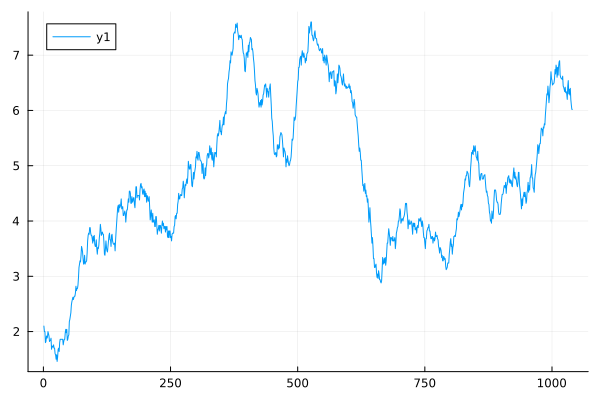

In [372]:
moving_average(opt.model.y, 50) |> plot

## Running a single configuration

In [58]:
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 1e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=2.0, s2=0.0, s3=0.05, s4=0.05,
                            Δ1=4.0Γ, Δ2=-0.8Γ, Δ3=-1.0Γ, Δ4=+0.5Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 4e-3)
;

In [59]:
results = simulate_particles_v2(package, params);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [60]:
density(params.t_end, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories)

36.24340520601817

## Scanning configurations

In [55]:
# fixed:
t_end = 30e-3 #s
n_values = 20
ramp_time = 4e-3 #s
B_gradient = 30 #G/cm

temp = @with_unit 0.5 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁺]

s1_list = [1.5, 2.0, 2.5]
s2_list = [0.0]
s3_list = [0.05, 0.1]
s4_list = [0.05, 0.1]

Δ1_list = [2.0, 4.0, 6.0] .* Γ
Δ2_list = [0.0]
Δ3_list = [-0.5, -1.0, -1.5] .* Γ
Δ4_list = [0.5, 1.0, 1.5] .* Γ

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan d3 +- 1MHz";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [
    1,1,1,1, 
    1,1,1,1, 
    1,1,1,1
];

In [ ]:
while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    s4 = s4_list[indicies[8]]
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles(package, params, params.n_values);

    save_results(saving_dir, test_i, results)
    
    scan_counter += 1 
    next_configuration!(lists, indicies)
    
end
;

============= configuration 1 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 2 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 3 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 4 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


============= configuration 5 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


============= configuration 6 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 7 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 8 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


============= configuration 9 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 10 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


============= configuration 11 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 12 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 13 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 14 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 15 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 16 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 17 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 18 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 19 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 20 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 21 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 22 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 23 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 24 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 25 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 26 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


============= configuration 27 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 28 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 29 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 30 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 31 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


============= configuration 32 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


============= configuration 33 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 34 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


============= configuration 35 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 36 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 37 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


============= configuration 38 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 39 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 40 / 324 =============


Progress:  70%|█████████████████████████████            |  ETA: 0:00:37┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


============= configuration 41 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


============= configuration 42 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


============= configuration 43 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


============= configuration 44 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:40


============= configuration 45 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


============= configuration 46 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


============= configuration 47 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 48 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 49 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 50 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 51 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 52 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


============= configuration 53 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 54 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 55 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


============= configuration 56 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 57 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 58 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 59 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


============= configuration 60 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 61 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 62 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 63 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 64 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


============= configuration 65 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 66 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


============= configuration 67 / 324 =============


Progress:  25%|███████████                              |  ETA: 0:04:54┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 68 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 69 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


============= configuration 70 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


============= configuration 71 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
